# Abstract
    This study approaches the challenge of how to infer stellar labels from spectra, where the training and testing data  are retrieved from the APOGEE. By building a generative stellar model inferred from a training set and minimizing the models log likelihood  a way of predicting stellar labels from spectra is found. That is the main goal of this study, but two other approaches using mcmc and a neural network are also touched upon. The study finds that all three methods are somewhat consistent in their results and error estimates. The mcmc approach is estimated to have the smallest errors, but the stellar model is still regarded as the best approach due to the fact that the mcmc is considered computationally expensive. The neural network imposes great potential, but is found to be insufficiently explored to yield competitive data. Fundamental in this study is the assumption that the labels estimated from the ASPCAP pipeline are more precise so that they can be taken as a basis for comparison for our model. A secondary aspect of this study is the exploration of the chemical compositions of the stars. The Fe/H composition is found to coincide quite well in the inferred general trends and positioning of labels in Kiel diagrams with theoretical isochrones and a study undertaken by Holtzman Et al. Another central aspect is data cleansing and processing. More specifically how to use bit masks and how to built upon previous data analysis in order to efficiently obtain analyze-ready spectra. The study is overall successful, with potential for further interesting developments.
    
# 0. INTRO

Throughout the last decades new spectroscopic surveys have provided us with stellar data from hundreds of thousands of stars across the sky. The Apache Point Observatory Galactic Evolution Experiment (APOGEE) is part of the Sloan Digital Sky Survey. A survey taking advantage of new, multi-object near-IR spectrography to provide high-resolution spectra of more than 150, 000 stars in the Milky Way [Holtzman Et al., 2015](https://arxiv.org/pdf/1501.04110.pdf). The data yields a huge opportunity to understand more of the kinematic and chemical structure of our galaxy. At the same time, the amount of available information also imposes a huge challenge in regards to how to efficiently do the analysis and abstraction of stellar labels from spectra. In this study we investigate methods for simultaneously abstracting stellar parameters and elemental abundances [X/Fe], refereed to as stellar labels, from multiple spectra. In this study we will infer efficient temperatures ($T_{eff}$), surface gravitation (log g) and the chemical abundances [Fe/H], [Si/Fe] and [Mg/Fe] of approximately 800 stars from the APOGEE survey.

In an attempt to find a solution to this challenge this study investigates three approaches to the data handling. One by constructing a generative probabilistic model, the second exploring mcmc applications and the third is applying a neural network on the spectra to infer the labels. The first of these methods are the main focus, while the two latter are subjected to less attention. Thus, the main goal of this study is to build a generative model to predict what a stellar spectrum should look like for a given set of stellar properties. Then to use this model to infer the properties of stars by fitting their spectra with the model. 

The first part of this study builds a training set based on data provided by the APOGEE survey. An initial set of spectra and errors of 2723 stars are downloaded from the SDSS server, and labels fitted to these spectra by the ASPCAP pipeline are downloaded as well. All spectra where one or more of the five desired labels are not presented are discarded, alongside spectra with low signal to noise ratio (SNR < 50) and spectra with low metallicity ([Fe/H] <−1). The remaining set consist of 1649 spectra, equally divided into a training and a testing set. The remaining spectra are then continuum-normalized so that the spectra can be used to train a model. Next the bit masks accompanying the spectra are applied to the set to filter out all the pixels with uncertain values that should not contribute significantly to the model. 
In part 2, 824 spectra are used to train a model. Then the model is applied to the testing set to infer the stellar labels. The labels are then compared to the values derived by the ASPCAP pipeline. In part 3 the labels are explored in a Kiel diagram, and compared to theoretical MIST SDSS isochrones of 6 Gyr and two metallicity values. The data is also compared to the study undertaken by Holtzman et al. In part 4 the model is wrapped in an mcmc and applied to fit for a mystery spectrum. Part 5 is returning to explore the chemical compositions by making an animation illustrating how the value of the Fe/H abundance affects a spectrum where all other parameters are kept fixed. This section also discusses the effect the presence of binary systems might have on the spectra used to train and test the model. In the final section, a neural network is applied to the data, constituting a third alternative for inferring stellar labels.

All three methods exhibit potential to be efficient tools in tackling this big challenge, but the scope of this potential also reaches beyond inferring stellar characteristics. Especially in regard to the mcmc approach and the neural network, the application to stellar label interference is just one example of potential applications ranging across social sciences, economics, physics and so forth. Optimizing log likelihoods as done to infer the stellar model also seems to be a good general method as long as an initial relationship like the one of the stellar spectra to the labels can be established. In this study we hope only to give one illustration of the power of these tools, and the utility they posses when applied to the was set of astronomical data. 

# PART 1: Retriving and cleansing spectra

## 1.A Section A

### 1.A.1 The APOGEE Survey

<p> The Apache Point Observatory Galactic Evolution Experiment (APOGEE) is a part of the Sloan Digital Sky Survey (SDSS-III2). A high resolution (R ∼ 22,500), high signal to noise (SNR > 100) spectroscopic survey operating in the infrared (H-Band, 15200-16900 Å) portion of the electromagnetic spectrum [Ness et. Al, 2015](https://arxiv.org/abs/1501.07604). By operating in the H-band APOGEE is particularly well-suited for light detection from stars lying in dusty regions of the Milky Way. Thus the main targets of the survey are spectra of red giant stars spanning the bulge, disk and halo of this galaxy captured by the 2.5 m Sloan Telescope. </p> 
<p>The Sloan Telescope samples stellar spectra on three chips. That is, the spectra are recorded onto three different detectors with a flux coverage of wavelengths ranging from 151400 to 169600 Å. These chips are referred to as "blue", "green" and "red", which should not be confused by the normal nomenclature of optical bands, ranging from shorter wavelengths to longer wavelengths. In between the detectors there are small gaps, leading to gaps in the wavelength coverage. The following table gives the coverage ranging of each chip. The starting and ending wavelengths vary slightly from fiber to fiber because of variations of their placement along the instrument pseudo-slit. The dispersion varies with wavelengths, and to a lesser extent, with fiber.  </p>

| Chip      | name | Start wavelength [$\mu$m]| End wavelength  [$\mu$m]|central dispersion [A/pix]
| ----------- | ----------- |----------- |----------- |----------- |
| a           | "red"       |1.647       |1.696       |-0.236|
| b           | "green"     |1.585       |1.644       |-0.283|
| c           |  "blue"      |1.514       |1.581       |-0.326|

Source: [SDSS: Using APOGEE Spectra](https://www.sdss.org/dr12/irspec/spectra/).

<p>The APOGEE survey started in September 2011, and has collected spectra for 148,000 stars in observations done through July 2014. This data is provided in the DR12, sorted in file types by the different types of spectrum provided by the DR12 and APOGEE/ASPCAP pipelines. The _apVisit_-files provide the individual visit spectra of each visit to each star. That is, one pseudo-continious recording of a stellar spectrum on the level where files are split by fiber. The _apStar_ files on the other hand provides the combined spectra of all stars. That is the coadded multivisit spectra derived from integrating over multiple single-visit spectra with at least one visit separated by at least one month. Looking at multiple single-visit spectra with restrictions on the cadence enables detection of radial velocity variations. This is useful as it  enables identifications of binary stars. In practice, the coadded multivisit spectra are then generated by resampling individual visits onto a common, logarithmically-spaced wavelength scale starting at 15100.802 Å, after removing each visits derived radial velocity. The resulting spectra are then in rest, vacuum wavelengths. This is done for most of the survey stars, and the coadded mulitvisit spectra are stored as the combinations of the data from multiple visits, by combining the data from all three chips. The process is described in greater detail at [APOGEE Visit Spectra Comination](https://www.sdss.org/dr12/irspec/spectral_combination/). The _aspcapStar_ files provides the pseudo-continuum normalized spectra and the derived stellar parameters from the APOGEE pipeline. It simply contains the ASPCAP results for an individual star [[SDSS.org](https://www.sdss.org/dr12/irspec/)].</p>

When the multivisit spectra are derived from the single-visit time series information usually with a required minimum of three visits for most targets [Ness et Al, 2015]. Some fainter targets were observed for more than three visits, and a subset of targets towards the Galactic Bulge was observed only in single visits. The latter due to the challenge associated with observing such targets from Apache Point observatory, where it is always at a high airmass. 

During the combination of the visit spectra to form the coadded spectra the Doppler shifts (I.e. radial velocity) are re-determined for each visit spectrum. This is done via a cross correlation between the object spectrum and a particular template [Majewski et Al., 2015]. The resampling process denoted above onto a common wavelength scale are effectively transforming the spectrum into the rest wavelength scale, that is a frame of no Doppler shift. Naturally this is necessary since the radial velocity in each visit for each star will vary in relation to the stars position relative to the observational point during the visit. As the single-visited spectra are measured at different times, often moths apart from each other, the radial velocity causing the Doppler shift is a factor that changes. Resampling all the visits on to a rest frame makes the data from different visits comparable to each other, so that it is possible to construct the coadded multi-visit spectra.  


The units of each spectra are given as 

<center>$$[10^{-17} erg/s/cm^2/Ang]$$</center>

where erg is a unit of energy and work equal to 10−7 Joules in the centimeter-gram-second system of physical units. The flux is therefore a measure of energy per second per centimeter, per Angstrom which just scales the estimate in the order of $10^{-10}$.

All spectra from DR12 are available form the SDSS server based on an assigned location ID, and can be downloaded directly from this host using the rsync or wget commands. 

###  1.A.2 Download spectra

In the SDSS server the spectra are sorted into different directories based on their "Location ID". This ID consist of a 4 digit number and corresponds to a particular line of sight in the survey. Within each of these directories the spectra are organized by their APOGEE ID, with naming conventions on the form of “apStar-r8-2M19395890+2258341.fits”. The 4 randomly chosen location IDs used to select a subset of the APOGEE multi visit spectra are **4230**, **4262**, **5162** and **4241**. All spectra associated with these directories are downloaded, using the wget command-line utility described in [this page](https://www.sdss.org/dr14/data_access/bulk/). See Appendix 1.A for more information about the restrictions imposed as command-line arguments. A subset of 2723 apStar-files are downloaded in _.fits_ file format.

The function __WGet\_apStar__ retrieves all spectra, and should only run once if the spectra is not already presented alongside this notebook. The same applies to the function __wget\_allstar__ in section B to download the allStar .fits files for the ASPCAP spectra labels. 

When retrieving all IDs, spectrum, spectrum error and bit masks from the .fits-files the wavelength array is reconstructed using the boundary wavelengths from the apStar.fits files as limits for an array evenly spaced on a logarithmic scale. The spectra of two 2 randomly selected stars are plotted to illustrate the general look of a spectrum.

In [1]:
""" Imports, generall settings and plot setting 
of notebook 
"""

from astropy.io import fits
import numpy as np
import os 
import pandas as pd
import matplotlib.pyplot as plt, matplotlib, seaborn as sns 
import corner
from tqdm import trange 
%matplotlib inline

# Suppress warnings
# Comment this out if you wish to see the warning messages
import warnings
warnings.filterwarnings('ignore')

# General Plot Layout Parameters
matplotlib.rcParams['figure.figsize']  = (20.0, 10.0)
matplotlib.rcParams['axes.grid']       = False
matplotlib.rcParams['font.size']       = 15
matplotlib.rcParams['font.family']     = 'OfficinaSanITCBoo'
matplotlib.rcParams['axes.labelsize']  = 0.9*plt.rcParams['font.size']
matplotlib.rcParams['axes.titlesize']  = 1.2*plt.rcParams['font.size']
matplotlib.rcParams['legend.fontsize'] = plt.rcParams['font.size']
matplotlib.rcParams['xtick.labelsize'] = 0.8*plt.rcParams['font.size']
matplotlib.rcParams['ytick.labelsize'] = 0.8*plt.rcParams['font.size']
matplotlib.rcParams['scatter.marker']  = 'o'
matplotlib.rcParams['axes.titlepad']   = 20 
matplotlib.rcParams['xtick.major.pad']='8'
matplotlib.rcParams['ytick.major.pad']='8'



In [2]:
def WGet_apStar():
    """ Downloading 2723 apStar files from the SDSS server
    using Wget command line
    """
    
    ! wget -r -q --no-parent -nd -e robots=off -P stars/4230/ -A 'apStar-r8-*.fits' -R 'apStar-r8-*-*.fits' https://data.sdss.org/sas/dr14/apogee/spectro/redux/r8/stars/apo25m/4230/
    ! wget -r -q --no-parent -nd -e robots=off -P stars/4262/ -A 'apStar-r8-*.fits' -R 'apStar-r8-*-*.fits' https://data.sdss.org/sas/dr14/apogee/spectro/redux/r8/stars/apo25m/4262/
    ! wget -r -q --no-parent -nd -e robots=off -P stars/5162/ -A 'apStar-r8-*.fits' -R 'apStar-r8-*-*.fits' https://data.sdss.org/sas/dr14/apogee/spectro/redux/r8/stars/apo25m/5162/
    ! wget -r -q --no-parent -nd -e robots=off -P stars/4241/ -A 'apStar-r8-*.fits' -R 'apStar-r8-*-*.fits' https://data.sdss.org/sas/dr14/apogee/spectro/redux/r8/stars/apo25m/4241/ 
        
#WGet_apStar()

In [3]:
def get_spectrum_data(path, location_id):
    """ Retriving ID, Spectrum, Error, Bitmask from path\location_id
    Reconstructing wavelength array in numpy logspace
    """
    ID_spec, Spectrum = [], []
    CRVAL1, CDELT1, NWAVE = [],[], []
    bitmask = []
    error = []
    for filename in os.listdir(path):
        with fits.open(path + filename) as hdul:
            ID_spec.append(location_id + '.' + hdul[0].header['OBJID'])
            Spectrum.append(hdul[1].data[1])
            CRVAL1.append(hdul[0].header['CRVAL1'])
            CDELT1.append(hdul[0].header['CDELT1'])
            NWAVE.append(hdul[0].header['NWAVE'])
            bitmask.append(hdul[3].data[0])
            error.append(hdul[2].data[0])
    CRVAL1, CDELT1, NWAVE = np.array(CRVAL1), np.array(CDELT1), np.array(NWAVE)
    Wavelengths = [np.logspace(CRVAL1[i], CRVAL1[i] + (NWAVE[i]-1)*CDELT1[i], NWAVE[i]) for i in range(len(CRVAL1))]
    d = {'ID_Spectrum':ID_spec,'Spectrum_ap': Spectrum, 'Wavelength_ap': Wavelengths, 
         'bitmask_ap': bitmask, 'ERROR_ap': error}
    df = pd.DataFrame(d)
    return df

def plot_2spectrum(idx1, idx2):
    """ Plots spectrum of stars with index idx1 and idx 2
    """
    fig = plt.figure(figsize=(15, 5))

    ax = fig.add_subplot(1, 2, 1);
    plt.plot(ApStar_data['Wavelength_ap'][idx1], ApStar_data['Spectrum_ap'][idx1])
    plt.ylabel(unit_flux)
    plt.xlabel('Wavelength [Ang]')
    plt.legend(['Flux'], loc = 'best')
    plt.title('Spectra of star %s' %ApStar_data['ID_Spectrum'][idx1]);

    ax = fig.add_subplot(1, 2, 2);
    plt.plot(ApStar_data['Wavelength_ap'][idx2], ApStar_data['Spectrum_ap'][idx2]);
    plt.ylabel(unit_flux)
    plt.xlabel('Wavelength [Ang]')
    plt.legend(['Flux'], loc = 'best')
    plt.title('Spectra of star %s' %ApStar_data['ID_Spectrum'][idx2]);

In [4]:
path_1, path_2, path_3, path_4 = 'stars/4230/','stars/4262/', 'stars/5162/', 'stars/4241/'

ApStar_4230 =  get_spectrum_data(path_1, '4230')
ApStar_4262 =  get_spectrum_data(path_2, '4262')
ApStar_5162 =  get_spectrum_data(path_3,'5162')
ApStar_4241 =  get_spectrum_data(path_4,'4241')
ApStar_data = pd.concat([ApStar_4230, ApStar_4262, ApStar_5162, ApStar_4241], ignore_index=True)
unit_flux   = 'Flux [10^-17 erg/s/cm^2/Ang]'

---------------------------------------------
Amount of files downloaded:  2723
---------------------------------------------



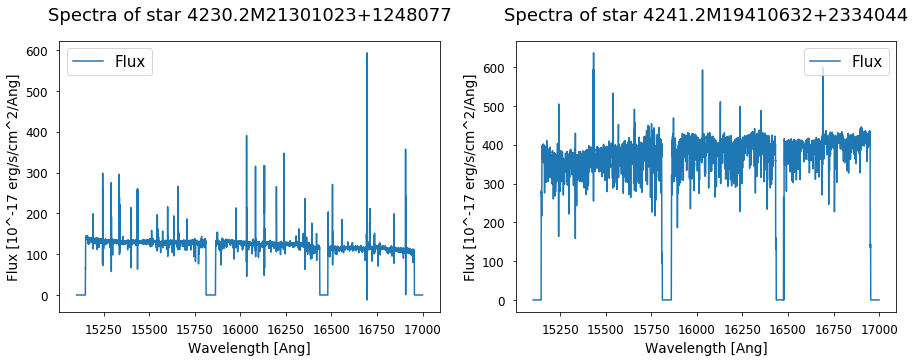

In [5]:
print('---------------------------------------------')
print('Amount of files downloaded: ', len(ApStar_data))
print('---------------------------------------------')
print('')

plot_2spectrum(0,2053)

## 1.B Section B

### 1.B.1 Download & Cleaning the spectra


To build a training set one needs to know the stellar properties, or _labels_, associated with a set of spectra similar to the ones the model is intended to be applied to. For this model these reference objects will be taken as the labels derived for the apStar files for each spectrum by the ASPCAP pipeline (Garcia-Perez et al. 2015). These can be found in the SDSS _allStar_ catalog. In the following section the labels Teff, logg, [Fe/H], [Mg/Fe], [Si/Fe] for all spectra obtained above are downloaded from the allStar .fits-files.

### 1.B.2 Cleaning the spectra

Due to data quality issues, not all labels have been derived for all stars. Therefore all spectra where any of the 5 labels relevant for the model are not derived are discarded. In th allStar catalog such values are labeled as _-9999_, and therefore easily detected. Furthermore, restrictions on spectra with low signal-to-noise ratio (SNR < 50) or low metallicity ([Fe/H] <−1) are discarded. A specific file of index 2349 in the database is also removed due to the fact that the spectra of this files reads out as a scalar value. Probably resulting from an error in the initial download of the data. This leaves in total 1649 spectra. The distribution of the labels are then visualized in label space using corner plot. 


In [6]:
def wget_allstar():
    ! wget -q -P stars/ https://data.sdss.org/sas/dr14/apogee/spectro/redux/r8/stars/l31c/l31c.2/allStar-l31c.2.fits
        
#wget_allstar()

In [7]:
def AllStar():
    ApStarID, Teff, logg, FeH, MgFe, SiFe, SNR = [], [], [], [], [], [], []
    Teff_ERR, logg_ERR, FeH_ERR, MgFe_ERR, SiFe_ERR = [], [], [], [], []
    with fits.open('stars/allStar-l31c.2.fits') as hdul:
        for i in range(len(hdul[1].data['APSTAR_ID'])):
            if hdul[1].data['APSTAR_ID'][i][22:].startswith(('4230','4262', '5162', '4241')):
                    ApStarID.append(hdul[1].data['APSTAR_ID'][i][22:])
                    MgFe.append(hdul[1].data['MG_FE'][i])
                    MgFe_ERR.append(hdul[1].data['MG_FE_ERR'][i])
                    SiFe.append(hdul[1].data['SI_FE'][i])
                    SiFe_ERR.append(hdul[1].data['SI_FE_ERR'][i])
                    SNR.append(hdul[1].data['SNR'][i])
                    Teff.append(hdul[1].data['TEFF'][i])
                    Teff_ERR.append(hdul[1].data['TEFF_ERR'][i])
                    logg.append(hdul[1].data['LOGG'][i])
                    logg_ERR.append(hdul[1].data['LOGG_ERR'][i])
                    FeH.append(hdul[1].data['FE_H'][i])
                    FeH_ERR.append(hdul[1].data['FE_H_ERR'][i])
    
    d = {'ID_Spectrum': ApStarID, 'MG_FE': MgFe, 'SI_FE': SiFe, 'SNR': SNR,
        'TEFF': Teff, 'LOGG': logg, 'FE_H': FeH, 'MG_FE_ERR': MgFe_ERR, 'SI_FE_ERR': SiFe_ERR,
        'TEFF_ERR': Teff_ERR, 'LOGG_ERR': logg_ERR, 'FE_H_ERR': FeH_ERR}
    
    df = pd.DataFrame(d)
    df_noDuplicates = df.drop_duplicates('ID_Spectrum')
    
    return df_noDuplicates

AllStar_data = AllStar()

comb = pd.merge(AllStar_data, ApStar_data, on =  'ID_Spectrum')

comb_cut = comb[~(comb['MG_FE'] == -9999.0) & ~(comb['SI_FE'] == -9999.0) & ~(comb['TEFF'] == -9999.0) 
                & ~(comb['LOGG'] == -9999.0) & ~(comb['FE_H'] == -9999.0)
                & (comb['SNR'] > 50) & (comb['FE_H'] > -1)]

data = comb_cut.drop(index = 2349).reset_index()

-------------------------------------------------------
Remaining amounts of spectras after all cuts:  1649
-------------------------------------------------------


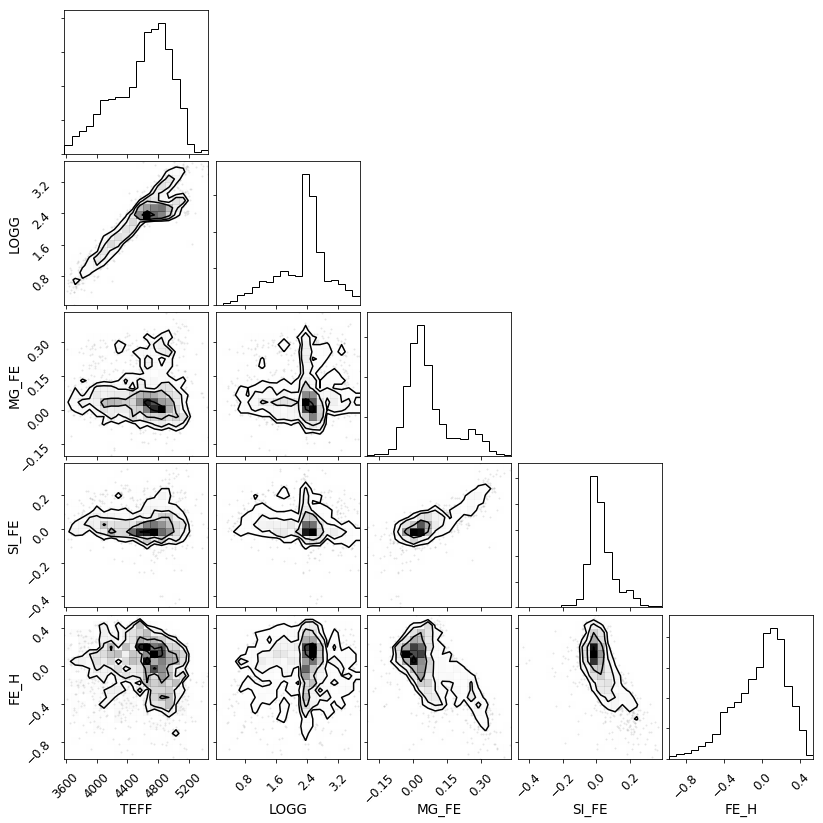

In [8]:
print('-------------------------------------------------------')
print('Remaining amounts of spectras after all cuts: ', len(data))
print('-------------------------------------------------------')

fig = corner.corner(data[['TEFF', 'LOGG', 'MG_FE', 'SI_FE', 'FE_H']])

## 1.C Section C

### 1.C.1 Pseudo-continuum Normalization

The model that is to be constructed will assume all spectra to be continuum-normalized in a consistent way, and sampled on a consistent rest-frame wavelength grid, with the same line-spread function, like stated by Ness et al [Ness et Al, 2015]. 

The theoretical definition of a continuum are pixels that are not affected by any absorption or emission lines, or in other words what the spectrum of a blackbody in vacuum with the same temperature and radius as the star would look like. This is in the real world not the case, as electromagnetic radiation observed here on earth have to pass through both dust attenuation and other atmospheric gases before we can reed it. As well as the fact that the signal is dependent on experimental environments such as sensitivity of the detector as a function of wavelength. Therefore our raw data are heavily affected by the "noise" raised from the absorption, emission and background effects affecting the signal along it's way from the star to earth. Therefore the observed spectra is primarily characterized by two components. The first one being the continuum, a theoretically generally smooth light spectrum emitted by the star. The second feature will on the other hand be lines caused by absorption of the radiation by specific atoms in the surrounding environment. The problem with this is that stars in an first instance can look like they have features that they actually do not exhibit. Like for example appearing twice as bright as a similar star due to having twice as many atoms in a specific state. This is obviously not the case. This is why the continuum-normalization is of importance. The continuum is invariant for this purpose, and can therefore serve as a reference point that is not dependent on such problematic effects  [Hall, 2018](http://www2.lowell.edu/users/jch/sss/article.php?r=t_datared_d_norm). As we in general do not know most of the dependence on the properties of these noisy effects, we can remove all of the effects so that the model only needs to predict the relative depth of the absorption lines. In other words, it is good practice to find pixels not heavily affected by these changing features in the model, and ideally not affected at all.


It is not easy to obtain such a blackbody radiation spectrum, but one can create a pseudo-continuum-normalization to approximate such a curve by doing a curve fit. Therefore the continuum-normalization is carried out by fitting a second order Chebychev polynomial to each chip in each spectrum for every star. To make sure that our fit is not heavily affected by the deep absorption line present in the spectra, one needs to do a selection of "good valued" pixels without such absorption lines. If these lines were present during the fit, we would in general get a difference between the shape of the fitted curve and the spectrum. For this purpose the pixels taken as such good pixels without absorption lines are provided by the apogee package (Distributed by Kareem).The authors of the package have identified a set of wavelength pixels that do not have any deep lines for stars with a wide range of spectral parameters. 

Taking these good wavelength pixels spanning a set of 7214 pixels, the spectra are re-sampled/interpolated by using scipy.interpolate.griddata onto this set. Then the accompanying boolean mask for good pixels are applied to make a selection of pixels that are well-suited to fit the underlying continuum. Obtaining coefficients from the curve fitted to these good pixels, and then creating three curves over the original wavelength grid of 8575 pixels distributed on each chip. Then dividing the spectra by this curve fit, we obtained the suitable first approach to the pseudo-continuum-normalized spectra. The continuum is set to 1.0 everywhere, and one can measure the lines from spectrum to spectrum in a consistent way. 

An example of the un-normalized spectrum, the derived pseudo-continuum and the normalized version of the spectrum are plotted.

In [9]:
from scipy.interpolate import griddata

Low_abs_wavelength  = np.load('wavelength.npy')
bolean              = np.load('pixels_cannon.npy')

spectrum            = data['Spectrum_ap'].as_matrix()
wavelengths         = data['Wavelength_ap'][0]
error               = data['ERROR_ap'].as_matrix()
ID                  = data['ID_Spectrum'].as_matrix()


N_stars             = len(spectrum)
N_pixels            = len(spectrum[0])
N_low_abs_pix       = len(Low_abs_wavelength)

In [10]:
def continuum_normalize(spec, wave,err, gridd_spectera):
    """ Continuum normalization of spectrums
    """
    
    clean_wavelengths   = gridd_spectera[bolean]
    Fit_pix             = griddata(wave, spec, gridd_spectera, method='nearest')
    Fit_err             = griddata(wave, err, gridd_spectera, method='nearest')

    cleaned_pixels      = Fit_pix[bolean]

    b_index             = np.array([0,240,0,3450])
    g_index             = np.array([241,348,3450,6200])
    r_index             = np.array([348,len(cleaned_pixels)-1,6200,N_pixels])

    blue                = channel_fit(b_index, cleaned_pixels, clean_wavelengths, wave, spec, err)
    green               = channel_fit(g_index, cleaned_pixels, clean_wavelengths, wave, spec, err)
    red                 = channel_fit(r_index, cleaned_pixels, clean_wavelengths, wave, spec, err)

    Curve_fit           = np.concatenate((blue[0],green[0],red[0]),axis = 0)
    Continuum_norm      = np.concatenate((blue[1],green[1],red[1]))
    Err_norm            = np.concatenate((blue[2],green[2],red[2]))
    
    return Curve_fit, Continuum_norm, Err_norm
    
    
def channel_fit(idx, cleaned_pixels, clean_wavelengths, wave, spec, error):
    
    cp                 = cleaned_pixels[idx[0]:idx[1]]
    cw                 = clean_wavelengths[idx[0]:idx[1]]
    
    coeff              = np.polynomial.chebyshev.chebfit(cw, cp, 2)
    Curve_fit          = np.polynomial.chebyshev.chebval(wave[idx[2]:idx[3]],coeff)

    cont_norm          = spec[idx[2]:idx[3]]/Curve_fit
    error_norm         = error[idx[2]:idx[3]]/Curve_fit
    
    return Curve_fit, cont_norm, error_norm

In [11]:
fitted_curve = np.zeros((N_stars,N_pixels))
norm_spectra = np.zeros((N_stars,N_pixels))
norm_error   = np.zeros((N_stars,N_pixels))

for i in range(N_stars):
    fitted_curve[i,:], norm_spectra[i,:], norm_error[i,:] = continuum_normalize(spectrum[i], wavelengths, error[i], Low_abs_wavelength)

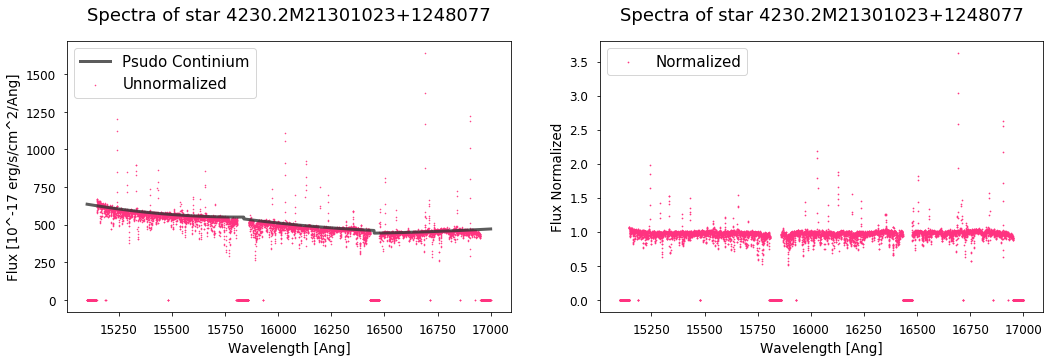

In [12]:
def sub_plot_spectrum(index):
    fig = plt.figure(figsize=(17.5, 5))

    ax = fig.add_subplot(1, 2, 1);
    plt.scatter(wavelengths, spectrum[index], c = (1,0.2,0.5), s = 0.3)
    plt.plot(wavelengths, fitted_curve[index], c = (0.2,0.2,0.2), linewidth = 3, alpha = 0.8)
    plt.legend(['Psudo Continium','Unnormalized'])
    plt.ylabel(unit_flux)
    plt.xlabel('Wavelength [Ang]')
    plt.title('Spectra of star %s' %ApStar_data['ID_Spectrum'][index]);

    ax = fig.add_subplot(1, 2, 2);
    plt.scatter(wavelengths, norm_spectra[index], c = (1,0.2,0.5),s = 0.5,label = 'Normalized')
    plt.ylabel('Flux Normalized')
    plt.xlabel('Wavelength [Ang]')
    plt.legend(['Normalized'])
    plt.title('Spectra of star %s' %ApStar_data['ID_Spectrum'][index]);

sub_plot_spectrum(0)



## 1.D Section D


### 1.D.1 Cleaning the spectra using bitmask

Each apStar spectrum comes with a bitmask which is a representation that keeps track of whether certain conditions are met in regards to the quality of the pixel. The conditions are tracked as bits following a binary representation of an integer, in a bitmask-encoded value called _flags_. The binary system will then unambiguously describe the status of each pixel. For example if we want to select pixels where CRPIX, SATPIX or NOSKY were marked as true, we would filter by the coding $2^1 + 2^2 + 2^7 = 134$. A full description of the bits and their binary representation can be found in the [SDSS information pages](https://www.sdss.org/dr14/algorithms/bitmasks/#APOGEE_PIXMASK). 

For the wavelengths where the bad pixels are found, the error of the spectrum is turned to a large value so that these pixels will contribute a minimum to the likelihood function when weighted in the model. As a first attempt at cleaning the spectra the badpix value is set to be equal to 4350. From there on the value is regulated to test if additional bits alter the result significantly. After some trial and error running, it is found that this value was acceptable for the purpose of this study.

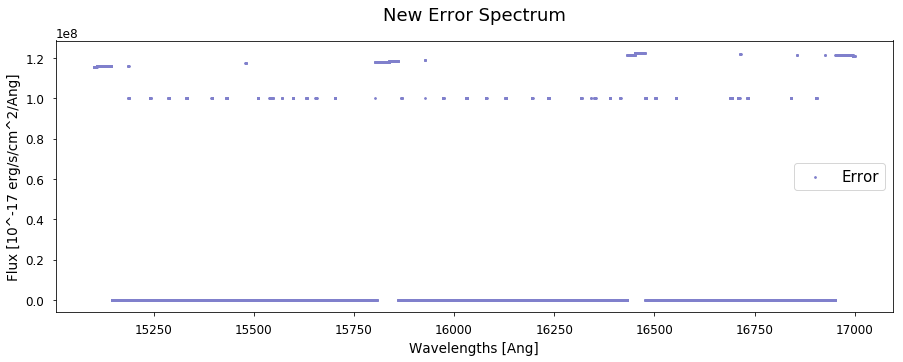

In [13]:
def clean_spectra(spectrum, error, bitmask):
    """ Adjusting uncertainties 
    """
    
    bolean_zeros_removal  = [(spectrum[i] == 0) for i in range(len(spectrum))]
    val_zeros             = np.array([10**8*bolean_zeros_removal[i] for i in range(len(error))]);

    # Set uncertanties high from bitmask
    binary_badpx          =   2**1 + 2**2 + 2**3 + 2**4 + 2**5 + 2**6 + 2**7 + 2**12
    bolean_badpix_filter  = [(bitmask[i] & binary_badpx) != 0 for i in range(len(bitmask))]
    val_badpix            = np.array([10**8*bolean_badpix_filter[i] for i in range(len(error))]);

    error_cut             = np.array(np.stack(norm_error, axis=0 ))
    error                 = error_cut+val_badpix +val_zeros
    
    return error
    
error_adjusted = clean_spectra(norm_spectra, norm_error, data['bitmask_ap'].as_matrix())    
    
    
plt.figure(figsize = (15,5));
plt.scatter(wavelengths,error_adjusted[0], s = 3, c = (0.5,0.5,0.8));
plt.xlabel('Wavelengths [Ang]');
plt.ylabel(unit_flux);
plt.legend(['Error'], loc = 'right')
plt.title('New Error Spectrum');

# 1.2 Discussion of part 1

The critical parts of this section is the pseudo-continuum-normalization and the bit mask cleansing. In regards to the former the Chebychev polynomial fitting of the normalization it were quite successful in normalizing all general tendencies in the spectra. The first time around attempting to do a normalization, a curve was fitted across all three chips. By altering this and fitting a curve to each band the results were unsurprisingly improved. However, when exploring the spectra using the various implemented plotting functions it was also evident that not all trends were successfully removed. Especially in the outermost regions of each band in each chip. To get a better hold of the continuum one could implement an approach like proposed and implementations by Ness Et al. where the result of the training model is used to improve the results of the preliminary pseudo-continuum. They found that they could get closer to the ASPCAP values by changing the percentiles of the modeled coefficients. When exploring the different binary compositions in applying the bit mask, the initial choice for the binary code was found sufficient. No other supplementary considerations seems to significantly alter the final results.


# 1.3 Results of part 1

The wget approach to downloading data and the pandas structure organization works as an efficient way of organizing the data. In total 2723 spectra was initially downloaded with errors, bit mask and wavelengths in what is considered an efficient manner. Discharging all spectra with insufficient signal to noise ratio, metallicity abundance below FE/H < -1 and spectra where the ASPCAP pipeline was unsuccessful in inferring the labels leaves 1649 spectra for further analysis.  The corner plot yields an illustrative representation of the covariances between the five selected labels, and successfully illustrates the covariance is apparent in every single relation. A continuum-normalization were done successfully to all spectra, with potential of improvement especially in the outermost regions of each band in each chip. Although it is found sufficiently successful for this purpose. 

# PART 2: Building a stellar model 

## 2.E Section E

###  2.E.1 Prepare training set

To create a model able to predict the labels as a function of each spectra, we need a training set and a set to test our model on. Therefore the set of 1649 stars are divided into two groups of 824 stars each, called the training- and the cross_validation set. All stars have spectra still in length of 8575 pixels. The selection is done at random by the sklearn module. The shuffle seems necessary in order to avoid any potential hidden covariances in the set. For reproducibility sake a seed is placed as random_state = 42.

Initially, a second order polynomial is chosen to fit the model. Therefore a 824x21 label matrix is constructed, containing rows for each of the 824 stars with columns that are quadratic in the labels:

<center> $\vec{l}_n = \begin{bmatrix}1 & T_{eff}, Log_G, Fe/H, ..., T_{eff}^2, T_{eff}Log_G,...\\
\end{bmatrix}$</center>

All 5 labels are scaled to unity using the standard scaler of sklearn.preprocessing.


### 2.E.2 About choice of labels

The term _labels_ refers to the characteristic properties of a stellar spectrum. These "stellar labels" is stellar parameters and element abundances [X/Fe], but for this purpose to treat them on a par. 
In this study I will focus on the parameters T$_{eff}$, log g, [Fe/H], [Mg/Fe] and [Si/Fe] but it should be noted that a wast variety of alternative properties like the age, stellar rotation and so forth could be included in the characterization. It is central to our approach that objects with the same labels have (nearly) identical spectra and that spectra vary smoothly with changes in the labels. As Ness et Al points out "This must be true, if the set of labels is comprehensive enough so that it fully specifies the star". Then our marginal selection of labels naturally becomes an approximation. It should although be mentioned that the Teff, log g and [Fe/H] are by far the most important to describe the overall behavior of the spectral flux of red giant stars [Ness et al.]

In [14]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
ASPCAP_labels = np.asmatrix([data['TEFF'].values, data['LOGG'].values, data['MG_FE'].values,data['SI_FE'].values,data['FE_H'].values] ).T
scaler.fit(ASPCAP_labels)
scaled_data = scaler.transform(ASPCAP_labels)

ASPCAP_labels_ERR = np.asmatrix([data['TEFF_ERR'].values, data['LOGG_ERR'].values, data['MG_FE_ERR'].values,data['SI_FE_ERR'].values,data['FE_H_ERR'].values] ).T

In [15]:
from sklearn.model_selection import train_test_split

N_labels = 21
labels = np.zeros((len(norm_spectra), N_labels))


labels[:,0] = np.ones(len(norm_spectra))
labels[:,1] = scaled_data[:,0]
labels[:,2] = scaled_data[:,1]
labels[:,3] = scaled_data[:,2]
labels[:,4] = scaled_data[:,3]
labels[:,5] = scaled_data[:,4]

labels[:,6] = labels[:,1]**2
labels[:,7] = labels[:,2]**2
labels[:,8] = labels[:,3]**2
labels[:,9] = labels[:,4]**2
labels[:,10] =labels[:,5]**2

labels[:,11] = labels[:,1]*labels[:,2]
labels[:,12] = labels[:,1]*labels[:,3]
labels[:,13] = labels[:,1]*labels[:,4]
labels[:,14] = labels[:,1]*labels[:,5]

labels[:,15] = labels[:,2]*labels[:,3]
labels[:,16] = labels[:,2]*labels[:,4]
labels[:,17] = labels[:,2]*labels[:,5]

labels[:,18] = labels[:,3]*labels[:,4]
labels[:,19] = labels[:,3]*labels[:,5]

labels[:,20] = labels[:,4]*labels[:,5]



ID_train, ID_test, labels_train, labels_test, labels_err_train, labels_err_test ,err_train, err_test, y_train, y_test = train_test_split(ID, labels, ASPCAP_labels_ERR, norm_error,  norm_spectra, test_size=0.5, random_state=42)
N_test = len(y_test)

## 2.F Section F

Having prepared a training set, the next step is to build a spectral model that predicts a spectrum at every wavelength pixel as a function of the 5 selected labels. 


### 2.F.1 Constructing a probabilistic generative model


A generative spectral model is then inferred from the spectra and stellar labels of a selection of reference objects. I.e a model that constructs, as a function of labels, a probability density function for the observed flux as a function of wavelengths. The model is built upon the 5 labels Teff, logg, [Fe/H], [Mg/Fe] and [Si/Fe].

The model is built upon the two basic notions as laid out by Ness et al:

1. _The continuum-normalized spectra of stars with identical labels look near identical at every pixel_
2. _The expected flux at every pixel changes continuously with changes in the labels_
    
As Ness et al states, looking away from the observational errors and intrinsic scattering, assumption 1 is true if the set of labels are exhaustive. I.e our model built upon 5 different labels must necessarily be an approximation to the full spectra inferred from an exhaustive label set. 

It is assumed that the spectral model can be characterized by a set of coefficients that allows to predict the flux at every pixel for a given label vector. Thus, the training set is used to derive a coefficient matrix $\vec{\Theta}_{\lambda}$ containing 21 coefficient for each label across all pixels. The first pixel is included to yield a linear offset in the fitting. The fitting is done by using a least squares method implemented in the numpy function _linalg.lstsq(labels, spectra)_. That is, solving for $\vec{\Theta}_{\lambda}$ in the expected flux relation:

<center>$f_{n,\lambda} = \vec{\Theta}_{\lambda}^T \cdot \vec{l}_n$ + noise</center>

The model will in the end be probabilistic and produce for every object spectrum at every wavelength, a pdf for the flux, with an expectation value and variance. 

Two additional features are applied while building the model. First the spectra are scaled by removing the mean and scaling to unit variance. This is done in the section above. Secondly, pixels with large uncertainties are down-weighted when training the model by applying the weights and solving for:


<center> $\vec{l}_n^TWf_{n,\lambda} = \vec{\Theta}_{\lambda}^T \cdot (\vec{l}_n^TW\vec{l}_n)$</center>

Where $W = 1/\sigma^2$ and $\sigma$ is the error matrix of all pixels in all spectra. 

In [16]:
def build_model(f, X, sigma):
    W = 1/sigma**2
    coeff = np.zeros((N_labels,N_pixels))

    for i in range(N_pixels):
        weight = np.diag(W[:,i])
        WA = np.matmul(X.T,np.matmul(weight,X))
        WB = np.matmul(X.T,np.matmul(weight,f[:,i]))
        
        coeff[:,i] = np.linalg.lstsq(WA,WB)[0]
    
    return coeff

theta = build_model(y_train, labels_train, err_train)

In [17]:
model_trained_data = np.matmul(theta.T, labels_train.T).T

In [18]:
def build_spectra(theta, labels):
    
    labels_full = np.zeros((1, N_labels))
    labels_full[0] = 1
    labels_full[:,1:6] = labels
    labels_full[:,6] = labels_full[:,1]**2
    labels_full[:,7] = labels_full[:,2]**2
    labels_full[:,8] = labels_full[:,3]**2
    labels_full[:,9] = labels_full[:,4]**2
    labels_full[:,10] =labels_full[:,5]**2

    labels_full[:,11] = labels_full[:,1]*labels_full[:,2]
    labels_full[:,12] = labels_full[:,1]*labels_full[:,3]
    labels_full[:,13] = labels_full[:,1]*labels_full[:,4]
    labels_full[:,14] = labels_full[:,1]*labels_full[:,5]

    labels_full[:,15] = labels_full[:,2]*labels_full[:,3]
    labels_full[:,16] = labels_full[:,2]*labels_full[:,4]
    labels_full[:,17] = labels_full[:,2]*labels_full[:,5]

    labels_full[:,18] = labels_full[:,3]*labels_full[:,4]
    labels_full[:,19] = labels_full[:,3]*labels_full[:,5]

    labels_full[:,20] = labels_full[:,4]*labels_full[:,5]
    
    return np.dot(theta,labels_full.T)

## 2.G Section G

To ensure that the model is working properly it is applied to the spectrum of the first object in the training set from it's labels. It is evident that the model and the actual spectrum are quite similar, but that they do have minor deviations. 

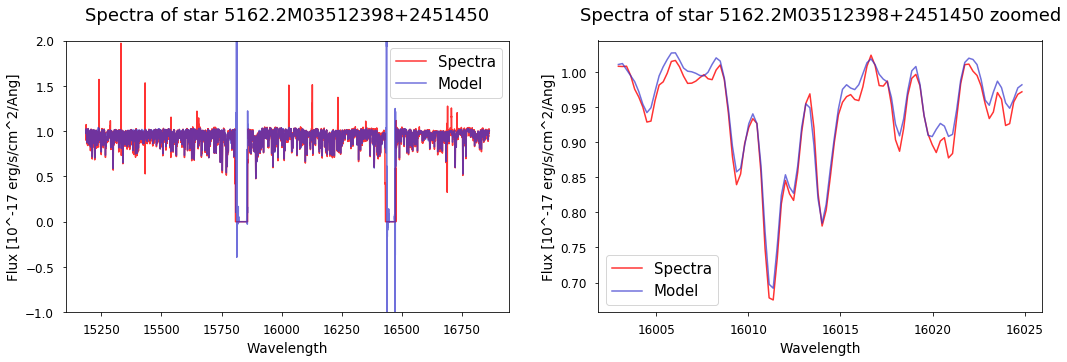

In [19]:
def plot_model(index, start, stop, start2, stop2):
    fig = plt.figure(figsize=(17.5, 5))

    ax = fig.add_subplot(1, 2, 1);
    plt.plot(wavelengths[start:stop], y_train[1][start:stop], c = (1, 0.2, 0.2))
    plt.plot(wavelengths[start:stop], model_trained_data[index][start:stop],alpha = 0.7, c = (0.2, 0.2, 0.8))
    plt.legend(['Spectra','Model'])
    plt.ylabel(unit_flux)
    plt.xlabel('Wavelength')
    plt.title('Spectra of star %s' %ID[index]);
    plt.ylim(-1,2)
    
    ax = fig.add_subplot(1, 2, 2);
    plt.plot(wavelengths[start2:stop2], y_train[1][start2:stop2],c = (1, 0.2, 0.2))
    plt.plot(wavelengths[start2:stop2], model_trained_data[index][start2:stop2],alpha = 0.7, c = (0.2, 0.2, 0.8))
    plt.legend(['Spectra','Model'])
    plt.ylabel(unit_flux)
    plt.xlabel('Wavelength')
    plt.title('Spectra of star %s zoomed' %ID[index]);

plot_model(10,400,8000,4200,4300)

## 2.H Section H

To test how well the model works, it is used to fit for the labels of spectra in the cross-validation set. An optimizer implemented through scipy's _optimize.minimize_ function are used to find the point in label-space at which a spectrum predicted by the model best matches the observed spectrum in an $\chi^2$ sense. 
To do so, the log likeliehood is taken as

<center> $\ln p(f_{n\lambda}|\vec{\theta}_\lambda^T,\vec{l}_n,s_\lambda^2) = -\dfrac{1}{2}\dfrac{[f_{n\lambda}-\vec{\theta}_\lambda^T\cdot\vec{l}_n]^2}{s_\lambda^2+\sigma_{n\lambda}^2}-\dfrac{1}{2}\ln(s_\lambda^2-\sigma_{n\lambda}^2)$ </center>

By finding the minimum of the negative of this log likelihood one finds the labels that are the best fit according to the model

<center> $ \{l_{mn}\} \leftarrow argmax_{\{l_{mn}\}}\sum_{\lambda=1}^{N_{pix}}\ln p(f_{n\lambda}|\vec{\theta}_\lambda^T,\vec{l}_n,s_\lambda^2)$</center>

The  predicted value is then plotted opposed to the ASPCAP-derived values for comparison. Both the bias and the scatter, I.e the root-mean-squear (RMS) value, are measured. 


In [20]:
from scipy.optimize import minimize

def ln_like(labels, y, err):
    inv_sigma2                  = 1.0/(err**2)
    model = build_spectra(theta.T, labels).T[0]
    P_nl = 0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2)))
    return P_nl

def model():
    results =  np.zeros((len(y_test), 5))
    for i in trange(len(y_test)):
        results[i,:] = minimize(ln_like, np.ones(5), args = (y_test[i], err_test[i]), method = 'L-BFGS-B').x
    return results

model_of_test = model()

100%|██████████| 825/825 [01:08<00:00, 11.59it/s]


In [21]:
Estimator = scaler.inverse_transform(model_of_test)
Apstar = scaler.inverse_transform(labels_test[:,1:6])

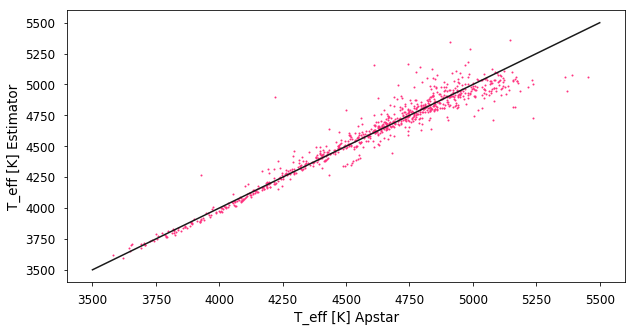

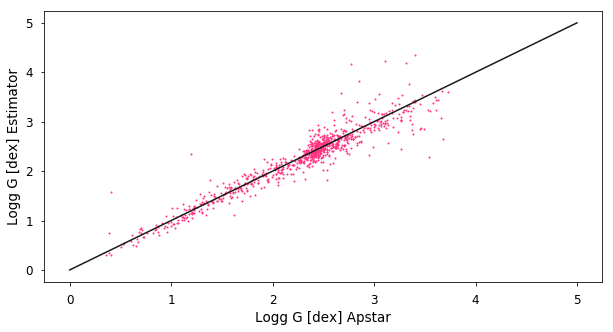

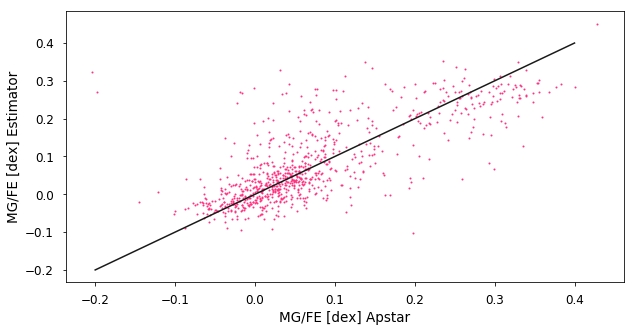

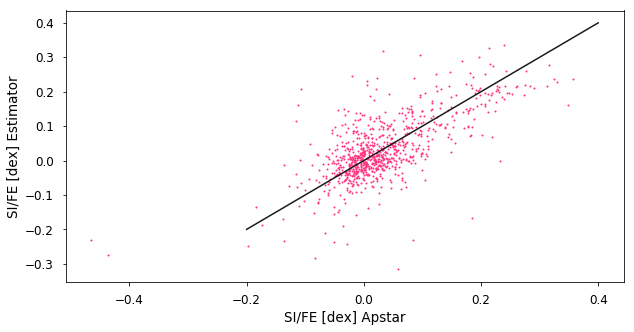

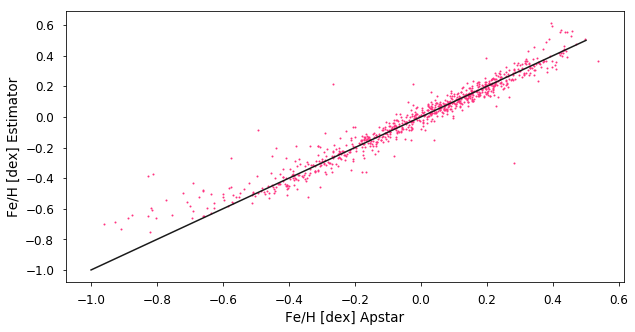

In [22]:
def plot_compar():
    idx = [i for i in range(len(Estimator[:,0]))]
    plt.figure(figsize = (10,5));
    plt.scatter(Apstar[:,0], Estimator[:,0], s = 1, c =  (1,0.2,0.5))
    plt.plot(np.linspace(3500,5500,len(idx)), np.linspace(3500,5500,len(idx)), c = (0.1,0.1,0.1))
    plt.xlabel('T_eff [K] Apstar');
    plt.ylabel('T_eff [K] Estimator');

    plt.figure(figsize = (10,5));
    plt.scatter(Apstar[:,1], Estimator[:,1], s = 1, c = (1,0.2,0.5))
    plt.plot(np.linspace(0,5,len(idx)), np.linspace(0,5,len(idx)), c = (0.1,0.1,0.1))
    plt.xlabel('Logg G [dex] Apstar');
    plt.ylabel('Logg G [dex] Estimator');

    plt.figure(figsize = (10,5));
    plt.scatter(Apstar[:,2], Estimator[:,2], s = 1, c = (1,0.2,0.5))
    plt.plot(np.linspace(-0.2,0.4,len(idx)), np.linspace(-0.2,0.4,len(idx)), c = (0.1,0.1,0.1))
    plt.xlabel('MG/FE [dex] Apstar');
    plt.ylabel('MG/FE [dex] Estimator');

    plt.figure(figsize = (10,5));
    plt.scatter(Apstar[:,3], Estimator[:,3], s = 1, c = (1,0.2,0.5))
    plt.plot(np.linspace(-0.2,0.4,len(idx)), np.linspace(-0.2,0.4,len(idx)),  c = (0.1,0.1,0.1))
    plt.xlabel('SI/FE [dex] Apstar');
    plt.ylabel('SI/FE [dex] Estimator');

    plt.figure(figsize = (10,5));
    plt.scatter(Apstar[:,4], Estimator[:,4], s = 1,c = (1,0.2,0.5))
    plt.plot(np.linspace(-1.0,0.5,len(idx)), np.linspace(-1.0,0.5,len(idx)),  c = (0.1,0.1,0.1))
    plt.xlabel('Fe/H [dex] Apstar');
    plt.ylabel('Fe/H [dex] Estimator');

plot_compar()

In [23]:
def error(true_spectrum, model_spectrum,label, unit):
    rms     = np.sqrt(np.sum(true_spectrum-model_spectrum)**2/(len(true_spectrum)-1))
    bias    = 1/len(true_spectrum)*np.sum(true_spectrum-model_spectrum)
    scatter = np.round(np.std(true_spectrum-model_spectrum),5)
    print("RMS        ", label,":   ",round(rms,3), unit)
    print("Bias       ", label,":   ", round(bias,3), unit)
    print('Scatter    ', label,':   ', round(scatter,3), unit)
    print('------------------------------------')
    return rms, bias, scatter

rms_T, bias_T, scatter_T = error(Apstar[:,0], Estimator[:,0], 'T_eff ', ' [K]')
rms_L, bias_L, scatter_L = error(Apstar[:,4], Estimator[:,4], 'Fe/H  ', " [dex]")
rms_L, bias_L, scatter_L = error(Apstar[:,1], Estimator[:,1], 'Logg G', " [dex]")
rms_L, bias_L, scatter_L = error(Apstar[:,2], Estimator[:,2], 'MG/FE ', " [dex]")
rms_L, bias_L, scatter_L = error(Apstar[:,3], Estimator[:,3], 'SI/FE ', " [dex]")

RMS         T_eff  :    46.375  [K]
Bias        T_eff  :    1.614  [K]
Scatter     T_eff  :    91.466  [K]
------------------------------------
RMS         Fe/H   :    0.268  [dex]
Bias        Fe/H   :    -0.009  [dex]
Scatter     Fe/H   :    0.069  [dex]
------------------------------------
RMS         Logg G :    0.36  [dex]
Bias        Logg G :    0.013  [dex]
Scatter     Logg G :    0.206  [dex]
------------------------------------
RMS         MG/FE  :    0.218  [dex]
Bias        MG/FE  :    -0.008  [dex]
Scatter     MG/FE  :    0.073  [dex]
------------------------------------
RMS         SI/FE  :    0.003  [dex]
Bias        SI/FE  :    0.0  [dex]
Scatter     SI/FE  :    0.069  [dex]
------------------------------------


## 2.2 Discussion of part 2

A label vector of the second order is found to produce sufficiently good results. It is evident when looking at the modeled spectra applied to the initial training spectra that there are deviations between the model and the initial spectra, as well as some fine structure tendencies that the model do not capture. Although, the model follows the general trends and absorption lines of all curves quite well. The main deviations between the model and the spectra is that the model generally fails to predict the highest peaks in the spectra, and have a higher error closer to the boundaries of each chip. This is material for further improvements in the future. 


## 2.3 Results of part 2

On a general basis, the model is quite successful in predicting values corresponding to the ASPCAP derived labels. The alignment is clearly better in the Fe/H abundances than in the Mg/Fe and Si/Fe abundances, and seems overall good for both effective temperature and surface gravitation. The RMS values in temperature equals 46.4 K and the RMS in Fe/H is found to be 0.268 dex. The Fe/H RMS is a higher than ideal, but the RMS is temperature seems very good. It is evident that all labels align quite well with the ASPCAP labels.



# PART 3: Exploring chemical composition trends

## 3.I Section I

A Kiel diagram is plotted for the 824 stars in the cross-validation set. The points are colored according to their Fe/H value. Two theoretical MIST SDSS isochrones of 6 Gyr are plotted above the cross-validation set. The extinction value for the isochrones is set to 0 in the lack of appropriate data, even though it is evident that this assumption is wrong. One isochrone is generated with solar metallicity, and the other one is generated with the relative metallicity Fe/H = -1. See [MIST](http://waps.cfa.harvard.edu/MIST/). 

Looking at the Kiel diagram it is evident that there is a line across the label-space where the surface gravitation and effective temperature tends to cluster around. The corresponding Kiel diagrams of Holtzman et al. with color coded with an overall solar-scaled chemical abundance [H/M], this is to be the expected general trend in metallicity. Especially since Holtzman et al assumes that the Fe abundance drives the overall metallicity in the APOGEE spectra. The model seems to predict results that generally coincides well with Holtzmans central clustering in the effective temperature-, surface gravitation- and metallicity abundance range. Moving towards higher temperatures in the Kiel diagram gives a general tendency of increase in the surface gravitation in both the model and in Holtzmans data. Although a varying range of Fe/H exists co-dependently across all cluster values for gravitation and temperature. 

Said more precisely, the model shows a tendency to have an increase in metallicity for a increase in surface gravitation at a given temperature. This feature is especially evident in the Holtzman et al data as well. Looking at the ASPCAP derived data presented in the second figure below, this trend is even more evident here than in our models predictions as well. Although there is a clear trend in the model of low metallicity on the upper bound regions of the cluster along decreasing values of log g, and a higher tendency to have higher metallicities on the lower regions of the cluster in label space [Holtzman et al, 2015](https://arxiv.org/abs/1501.04110).

This trend is further supported by the isochrones. The isochrone with a solar-scaled metallicity of Fe/H = -1 have lower surface gravitation than the Fe/H = 0 isochrone for a given temperature. This is in good agreement with the trend of the model data as it  seems like most of the clustering predicted by the model lays somewhere in between the two isochrones. Furthermore the model shows a majority of Fe/H values in the region from 0.0 dex to -0.8 dex and a trend to increase abundance by increased log g. The isochrone almost seems to over estimate the Fe/H abundance in regards to the model data. This might after all not be so surprising, due to the fact that the isochrone was derived on an assumption of zero extinction. An assumption that is clearly wrong. By taking this factor into consideration the isochrone would shift towards higher temperatures and probably coincide better with our model based on spectra taken on earth. This feature is although considered to be beyond the scope of this analysis and further examination is required to determine if this is an accurate prediction. 

The last thing that should be mentioned is the Apstar catalog data tends to branch out into two separate cluster regions in the highest ends of the temperature and log g ranges. Each of the branches interestingly enough seems to have a separate Fe/H metallicity ratio going from hight to low with decreasing log g. This feature is although not present in the models data, which is an indicator that our model misses to predict some central features. That is if the Apstar data is taken as correct. The data also seems to be more uncertain for the few outliers of the Kiel diagram. The model data rarely coincides with the ASPCAP values for the furthermost stars. 

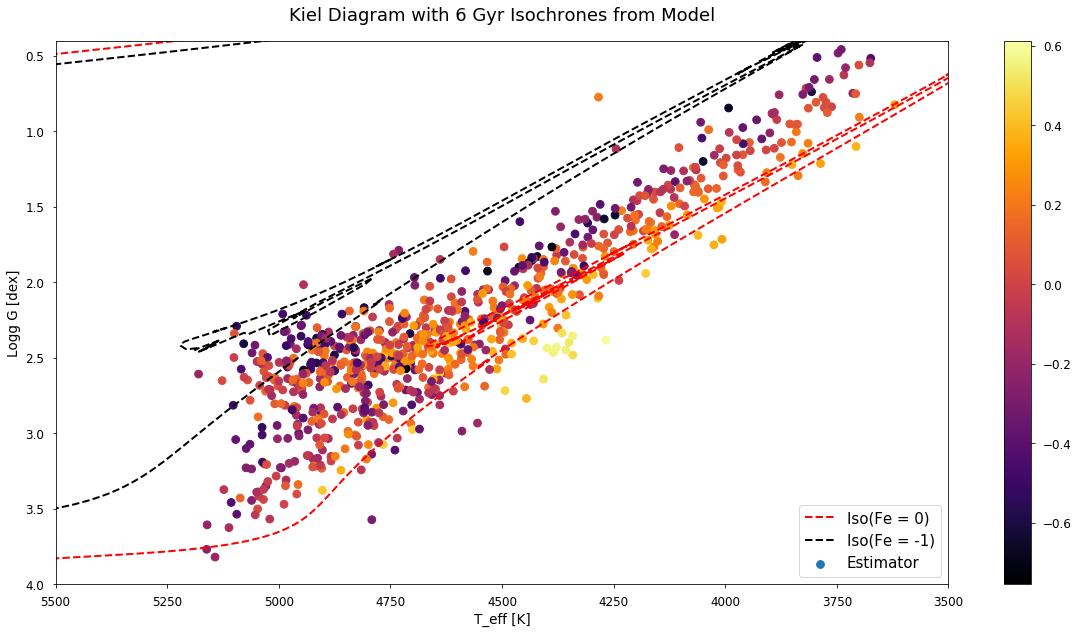

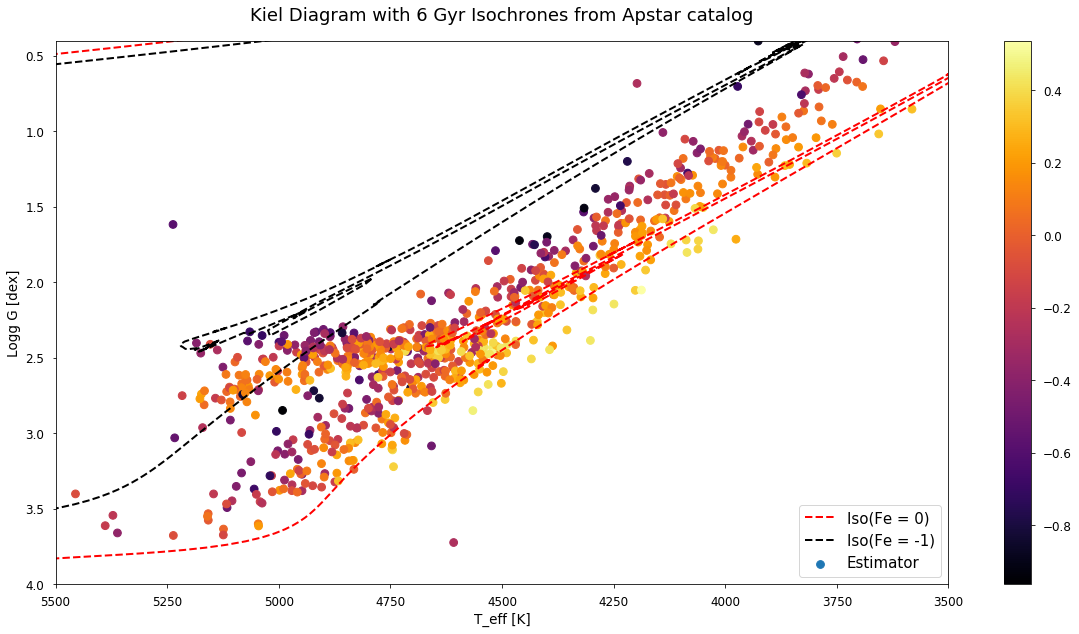

In [24]:
plt.figure(figsize = (20,10));
plt.scatter(Estimator[:,0], Estimator[:,1],c =  Estimator[:,4], s = 60, cmap = 'inferno') ;
plt.colorbar()
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.xlabel('T_eff [K]');
plt.ylabel('Logg G [dex]');
plt.xlim((5500,3500))
plt.ylim((4,0.4))

Iso_1 = np.loadtxt("SDSS_6Gyr_Fe-1.cmd", skiprows = 13, usecols = (4,5))
Iso_0 = np.loadtxt("SDSS_6Gyr_Fe0.cmd", skiprows = 13, usecols = (4,5))
Iso_0[:,0] = 10**(Iso_0[:,0])
Iso_1[:,0] = 10**(Iso_1[:,0])

plt.plot(Iso_0[:,0], Iso_0[:,1], '--r', linewidth=2);
plt.plot(Iso_1[:,0], Iso_1[:,1], '--k', linewidth=2);
plt.title('Kiel Diagram with 6 Gyr Isochrones from Model')
plt.legend(['Iso(Fe = 0)', 'Iso(Fe = -1)','Estimator']);

###############################################################################################################

plt.figure(figsize = (20,10));
plt.scatter(Apstar[:,0], Apstar[:,1],c =  Apstar[:,4], s = 60, cmap = 'inferno') ;
plt.colorbar()
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.xlabel('T_eff [K]');
plt.ylabel('Logg G [dex]');
plt.xlim((5500,3500))
plt.ylim((4,0.4))

plt.plot(Iso_0[:,0], Iso_0[:,1], '--r', linewidth=2);
plt.plot(Iso_1[:,0], Iso_1[:,1], '--k', linewidth=2);
plt.title('Kiel Diagram with 6 Gyr Isochrones from Apstar catalog')
plt.legend(['Iso(Fe = 0)', 'Iso(Fe = -1)','Estimator']);

# PART 4: Using mcmc to fit for a mystery spectrum

## 4.J Section J

In this section the spectral model is wrapped in an MCMC used to fit a provided mystery spectrum. Due to the spectra being continuum-normalized and the labels being normalized all uninformed priors are restricted to $\pm 5$. Diagnostics plot of the convergence in the 5 label parameters and a corner plot of the constraints on the five labels is provided.

The formal errors of the fit seems to be of an acceptable order of magnitude. Looking at the errors in the scaled fit the error is of order one percent. This is consistent with the errors inferred from the ASPCAP data for both effective temperature and surface gravitation. It is on the other hand a bit smaller than the average ASPCAP errors for the metallicities. For Mg/Fe and Si/Fe the errors inferred by ASPCAP are two orders of magnitude larger, and for Fe/H it is one order of magnitude larger than the McMc inferred errors.  

Compared to the typical errors inferred from the scatter in the cross-validation the two estimates are in pretty good agreement. The error in temperature in both cases are of order one percent, and the errors in the abundances and log g are in the order of 10 percent. Presumingly the errors in the cross-validation seems a bit larger on average relative to the McMc errors. 

That the errors do not perfectly coincide is to be expected as the methods used to infer the data are different. Changes in errors between ASPCAP and this model are most likely due to the fact that ASPCAP undertook a more thorough analysis of the data with a broader perspective on the environment of the observations and the amount of parameters taken into consideration. That the errors in the McMc approach also seems a bit lower is not surprising either, due to the methods more thorough investigations of convergence amongst the parameters. Still, the results produced from the model seems to be acceptable for this purpose. 

In [25]:
def open_mystery_spec():
    """ Open mystery spectrum
    """
    
    ID_spec, mystery_spectrum = [], []
    CRVAL1, CDELT1, NWAVE = [],[], []
    mystery_bitmask = []
    mystery_error = []
    
    with fits.open('stars/mystery_spec_wiped.fits') as hdul:
        ID_spec.append(hdul[0].header['OBJID'])
        mystery_spectrum.append(hdul[1].data)
        CRVAL1.append(hdul[0].header['CRVAL1'])
        CDELT1.append(hdul[0].header['CDELT1'])
        NWAVE.append(hdul[0].header['NWAVE'])
        mystery_bitmask.append(hdul[3].data)
        mystery_error.append(hdul[2].data)
    CRVAL1, CDELT1, NWAVE = np.array(CRVAL1), np.array(CDELT1), np.array(NWAVE)
    mystery_wavelengths = [np.logspace(CRVAL1[i], CRVAL1[i] + (NWAVE[i]-1)*CDELT1[i], NWAVE[i]) for i in range(len(CRVAL1))]
    
    mystery_spectrum = np.array(mystery_spectrum[0])
    mystery_wavelengths = np.array(mystery_wavelengths[0])
    mystery_error = np.array(mystery_error[0])
    
    return mystery_spectrum, mystery_wavelengths, mystery_error, ID_spec

def sub_plot_spectrum2(curve_fit, spectrum, normalized_spectrum, wavelength, ID):
    fig = plt.figure(figsize=(17.5, 5))

    ax = fig.add_subplot(1, 2, 1);
    plt.scatter(wavelength, spectrum, s = 0.5, c = (1,0.2,0.5))
    plt.plot(wavelength, curve_fit, 'r', c = (0.1,0.1,0.1))
    plt.legend(['Psudo Continium','Unnormalized'])
    plt.ylabel('Flux')
    plt.xlabel('Wavelength')
    plt.title('Spectra of star %s' %ID);

    ax = fig.add_subplot(1, 2, 2);
    plt.scatter(wavelength, normalized_spectrum, s = 0.5,label = 'Normalized', c = (1,0.2,0.5))
    plt.ylabel('Flux')
    plt.xlabel('Wavelength')
    plt.legend(['Normalized'])
    plt.title('Spectra of star %s' %ID);


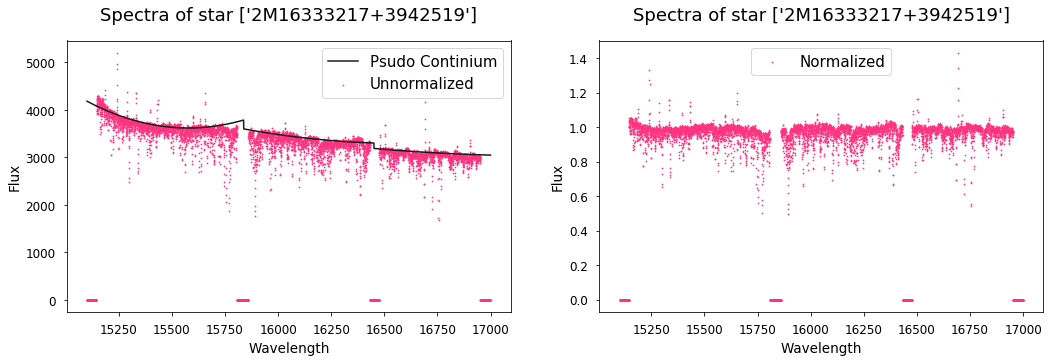

In [26]:
mystery_spectrum, mystery_wavelengths, mystery_error, ID_spec = open_mystery_spec()

mcv, mns, mne = continuum_normalize(mystery_spectrum, mystery_wavelengths,mystery_error, Low_abs_wavelength)

sub_plot_spectrum2(mcv,mystery_spectrum, mns, mystery_wavelengths, ID_spec)

In [27]:
""" Line fit tools
"""
def lnlike(labels, y, err):
    inv_sigma2                  = 1.0/(err**2)
    model = build_spectra(theta.T, labels).T[0]
    P_nl = -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2)))
    return P_nl

def lnprior(theta):
    """ Takes theta as argument {a,b,c,d,e}, and 
    returns log-prior if priors are within bounds or -infty if priors are outside of bounds.
    """
    a, b, c, d, e = theta
    if -5 <= a <= 5 and -5 <= b <= 5 and -5 <= c <= 5 and -5 <=  d <= 5 and -5 <= e <= 5:
        return 0.0
    return -np.inf


def lnprob(theta, x, y, yerr):
    """ Takes in theta = {a,b} and data (x,y,error in y). 
    Returns a log probability if finite, and -inf if not finite
    """
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, y, yerr)


def fit_G_band_line(seed, x, y_data, niterations, y_err):
    """ 
    
    Implementing burnin by removing the first 200 steps
    They are still sensitive to the initial conditions
    """
    # Sampeling the posterior using emcee
    rnd = np.random.RandomState(seed)
    
    ndim, nwalkers = 5, 16
    initial_a, initial_b, initial_c, initial_d, initial_e = 0.7,0.7,0.7,0.7,0.7
    pos = [(initial_a, initial_b, initial_c, initial_d, initial_e) + 1e-4*rnd.randn(ndim) for i in range(nwalkers)]
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y_data, y_err))
    
    start_time = time.time()
    sampler.reset()
    sampler.run_mcmc(pos, niterations)

    end_time = time.time() - start_time
    print(f"This run took: {np.around(end_time,2)} seconds")

    return sampler, y_err

In [28]:
import emcee, time, corner

sampler_rrl, y_err_in =  fit_G_band_line(420, mystery_wavelengths, mns, 30000, mne)


This run took: 309.39 seconds


In [29]:
""" Plotting functions for the line fit
"""
def m_b_step_plot(sampler):
    print("Chain shape:      ", sampler.chain.shape) # ndim, nwalker, # of parameters
    print('Flat chain shape: ',sampler.flatchain.shape,"\n") # ndim * nwalker, # of parameters 

    fig, ax = plt.subplots(5,1, figsize=(15,20))
    y_labels = ['$a$', '$b$', '$c$', '$d$', '$e$']
    x_labels = 'step'
    ax[0].set_title('Parameter Value vs. Step Number for each walker')
    #print(sampler.chain.shape)
    for i,j in enumerate(sampler.chain[0,0,:]):
        ax[i].plot(sampler.chain[:,:,i].T, alpha=0.8, lw=0.5)
        ax[i].set_ylabel(y_labels[i])
        ax[i].set_xlabel(x_labels)
    plt.subplots_adjust(hspace=0.4)
    
    plt.figure(figsize = (15, 5))
    plt.plot(sampler.lnprobability.T)
    plt.ylabel('lnP')
    plt.xlabel('step')
    plt.title('lnP vs. step number')
    
    plt.figure(figsize = (15, 5))
    plt.plot(sampler.lnprobability.T[5000:])
    plt.ylabel('lnP')
    plt.xlabel('step')
    plt.title('lnP vs. step number')
    #plt.ylim(-50, sampler.lnprobability.max()*1.5)
    #plt.ylim(sampler.lnprobability.min(), sampler.lnprobability.max()*1.5)

    
def corner_plot(sampler):
    ndim, nwalkers = 5, 16
    burn_in = 10000
    samples = sampler.chain[:, burn_in:, :].reshape((-1, ndim))
    #print(f"corner version={corner.__version__}")
    fig = corner.corner(samples, labels=['$a$', '$b$', '$c$', '$d$', '$e$'],quantiles=[0.16, 0.84])    


def draws_posterior(sampler,x,y_data,y_err):
    burn_in = 10000
    ndim, nwalkers = 5, 16
    samples = sampler.chain[:, burn_in:, :].reshape((-1, ndim))
    plt.figure(figsize = (15,5))
    # create an array of x values
    # randomly draw 50 points from my posterior (i.e., the MCMC chain)
    # and plot them as thin black lines
    for a, b, c, d, e in samples[np.random.randint(len(samples), size=50)]:
        label = np.array([a,b,c,d,e])
        model = build_spectra(theta.T, label).T[0]
        plt.plot(x[200:700], model[200:700], color="k", alpha=0.1)


    # plot the fake data with error bars
    #plt.errorbar(x, y_data, yerr=y_err, ls='none', marker='o', ms=1, c='orange', label='Errorbars')
    plt.plot(x[200:700], y_data[200:700], 'b', ms = 10, marker = '.', ls = 'none', label = 'Data');        
    plt.legend(['McMc Estimates', 'Spectrum'])
    #set some limits on the plot
    plt.xlabel("Wavelength [Ang]", fontsize=20)
    plt.ylabel("Flux [10^-17 erg/s/cm^2/Ang]", fontsize=20)
    #plt.xlim(-1, 0.95)
    plt.ylim(-2,3)
    plt.tight_layout()
    

    #compute summary statistics: 50, 16, 84 percentiles
    a_mcmc, b_mcmc, c_mcmc, d_mcmc, e_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                                 zip(*np.percentile(samples, [16, 50, 84],
                                                    axis=0)))

    plt.figure(figsize = (15, 5))
    plt.plot(x[200:700], y_data[200:700], 'b',  label = 'Data', linewidth=2);
    label_mcmc = np.array([a_mcmc[0], b_mcmc[0], c_mcmc[0], d_mcmc[0], e_mcmc[0]])
    model_mcmc = build_spectra(theta.T, label_mcmc).T[0]
    plt.plot(x[200:700], model_mcmc[200:700], c = (1,0.2,0.5), label = "Median Fit",alpha = 0.6, linewidth=2)
    plt.ylim((0.4,1.2))
    plt.legend()
    plt.xlabel("Wavelength [Ang]", fontsize=20)
    plt.ylabel("Flux [10^-17 erg/s/cm^2/Ang]", fontsize=20)
    plt.tight_layout()
    plt.legend(frameon=True, fontsize=14)

    print(f"mcmc median, +/- for a: {a_mcmc}\n")
    print(f"mcmc median, +/- for b: {b_mcmc}\n")
    print(f"mcmc median, +/- for c: {c_mcmc}\n")
    print(f"mcmc median, +/- for d: {d_mcmc}\n")
    print(f"mcmc median, +/- for e: {e_mcmc}\n")
    return a_mcmc, b_mcmc, c_mcmc, d_mcmc, e_mcmc

Chain shape:       (16, 30000, 5)
Flat chain shape:  (480000, 5) 

mcmc median, +/- for a: (-0.1994171235383998, 0.0023749314297439594, 0.0023541242643836113)

mcmc median, +/- for b: (-0.414483124802944, 0.003572988973886526, 0.0035927395174116805)

mcmc median, +/- for c: (1.5010597734951696, 0.005887159004135389, 0.005690787010495635)

mcmc median, +/- for d: (1.8353762437044354, 0.007533137924130351, 0.007593407618240233)

mcmc median, +/- for e: (-1.8051013044653355, 0.0031179973541484163, 0.003146290226207382)



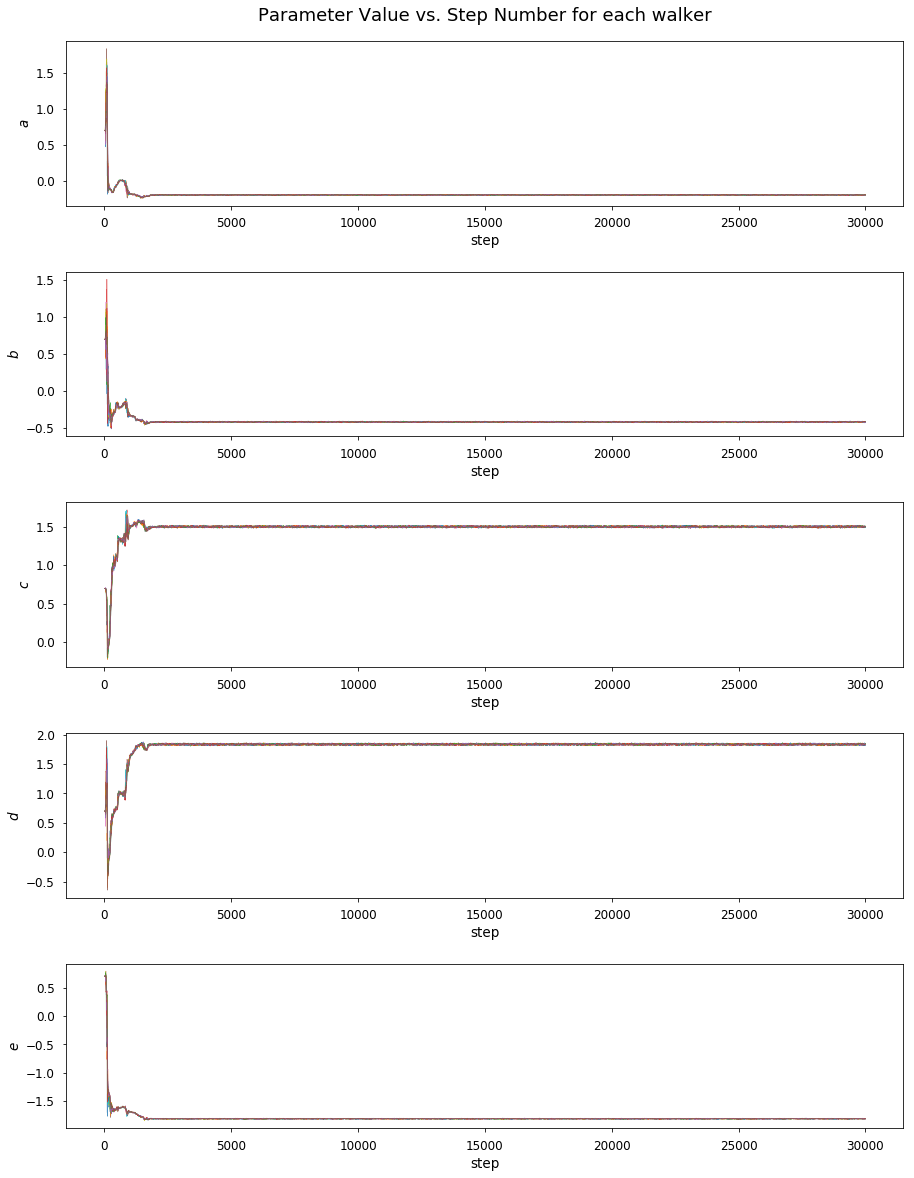

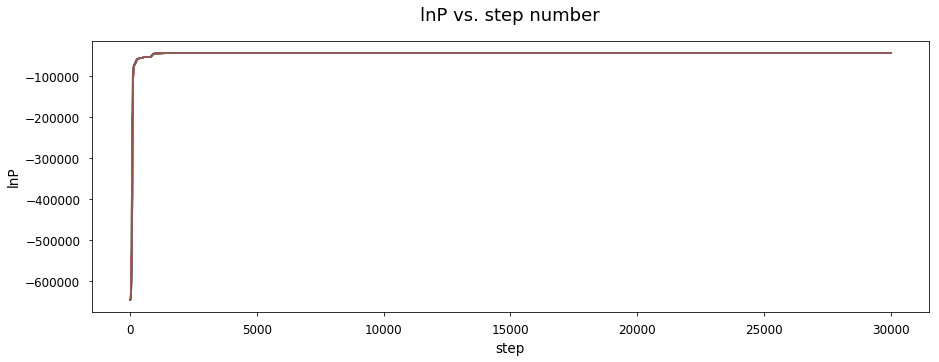

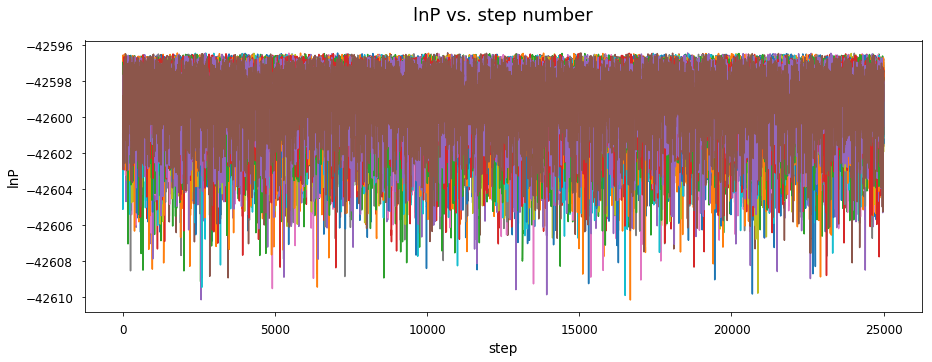

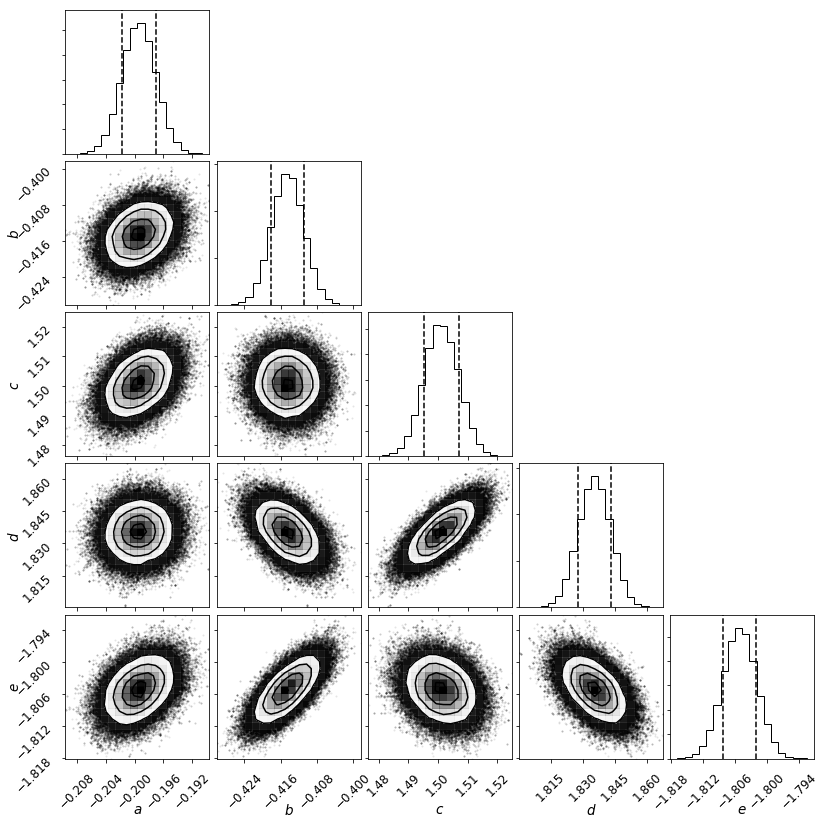

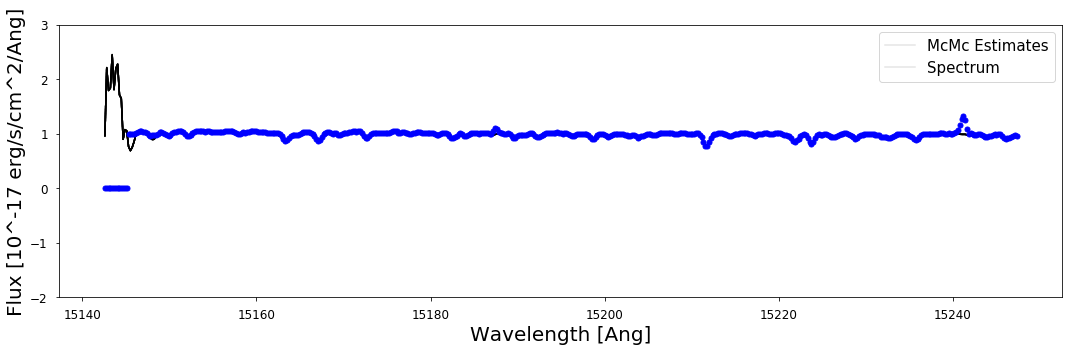

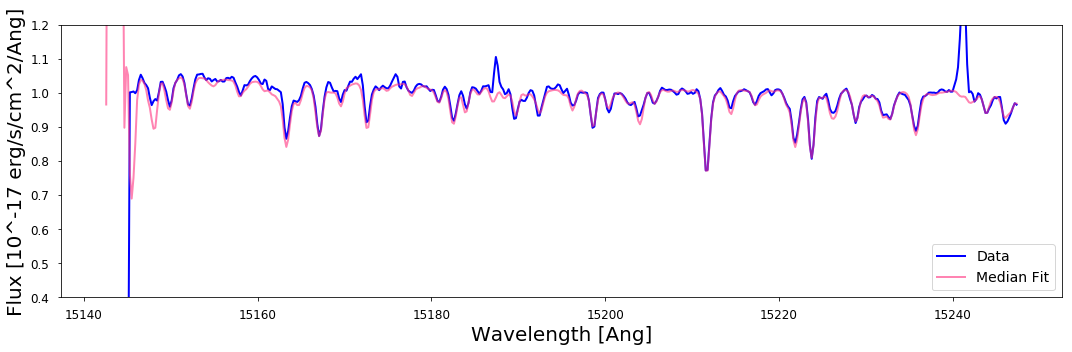

In [30]:
m_b_step_plot(sampler_rrl)

corner_plot(sampler_rrl)

a_1,b_1,c_1,d_1,e_1 = draws_posterior(sampler_rrl, mystery_wavelengths, mns,mystery_error)


In [31]:
param      = [a_1[0],b_1[0],c_1[0],d_1[0],e_1[0]]
param_err  = [(a_1[1]+a_1[2])/2, (b_1[1]+b_1[2])/2, (c_1[1]+c_1[2])/2, (d_1[1]+d_1[2])/2, (e_1[1]+e_1[2])/2]
parameters = scaler.inverse_transform(param)
#parameters_err = scaler.inverse_transform(param_err)


print('\n-----------------------MCMC VALUES SCALED:------------------------------\n')

print('T eff:  ', round(parameters[0], 3),  ' [K]')
print('Logg G: ', round(parameters[1], 3),  '    [dex]')
print('Mg_Fe:  ', round(parameters[2], 3),  '    [dex]')
print('Si_Fe:  ', round(parameters[3], 3),  '    [dex]')
print('Fe_H:   ', round(parameters[4], 3), '   [dex]')
print('-------------------------------------------------------------------------\n\n')

print('\n----------------------MCMC VALUES AND ERRORS - Not Scaled ---------------\n')

print('T eff:  ', round(param[0], 3),'    \pm ',round(param_err[0],3), '    [K]')
print('Logg G: ', round(param[1], 3),'    \pm ',round(param_err[1],3),  '    [dex]')
print('Mg_Fe:  ', round(param[2], 3),'     \pm ',round(param_err[2],3),  '    [dex]')
print('Si_Fe:  ', round(param[3], 3),'     \pm ',round(param_err[3],3),  '    [dex]')
print('Fe_H:   ', round(param[4], 3),'    \pm ',round(param_err[4],3),  '    [dex]')
print('-------------------------------------------------------------------------\n\n')


Teff_mean_err = (np.mean(labels_err_train[:,0]) + np.mean(labels_err_test[:,0]))/2
Logg_mean_err = (np.mean(labels_err_train[:,1]) + np.mean(labels_err_test[:,1]))/2
MgFe_mean_err = (np.mean(labels_err_train[:,2]) + np.mean(labels_err_test[:,2]))/2
SiFe_mean_err = (np.mean(labels_err_train[:,3]) + np.mean(labels_err_test[:,3]))/2
FeH_mean_err  = (np.mean(labels_err_train[:,4]) + np.mean(labels_err_test[:,4]))/2

def print_err(err, label, unit):
    print('----------------------------------------------------')
    print('Mean error in  ASPCAP label ',label,' :', round(err,3), ' ', unit)

    
    
print('-----------------------AVERAGE ERRORS IN ASPCAP LABELS:------------------\n\n')

print_err(Teff_mean_err, 'T_eff', '[K]')
print_err(Logg_mean_err, 'Log g', ' [dex]')
print_err(MgFe_mean_err, 'Mg/Fe', '  [dex]')
print_err(SiFe_mean_err, 'Si/Fe', ' [dex]')
print_err(FeH_mean_err, 'Fe/H ', ' [dex]')
print('-------------------------------------------------------------------------')




-----------------------MCMC VALUES SCALED:------------------------------

T eff:   4511.753  [K]
Logg G:  1.995     [dex]
Mg_Fe:   0.226     [dex]
Si_Fe:   0.185     [dex]
Fe_H:    -0.511    [dex]
-------------------------------------------------------------------------



----------------------MCMC VALUES AND ERRORS - Not Scaled ---------------

T eff:   -0.199     \pm  0.002     [K]
Logg G:  -0.414     \pm  0.004     [dex]
Mg_Fe:   1.501      \pm  0.006     [dex]
Si_Fe:   1.835      \pm  0.008     [dex]
Fe_H:    -1.805     \pm  0.003     [dex]
-------------------------------------------------------------------------


-----------------------AVERAGE ERRORS IN ASPCAP LABELS:------------------


----------------------------------------------------
Mean error in  ASPCAP label  T_eff  : 74.329   [K]
----------------------------------------------------
Mean error in  ASPCAP label  Log g  : 0.053    [dex]
----------------------------------------------------
Mean error in  ASPCAP label  Mg/

## 4.2 Discussion of part 4

The mcmc way of inferring stellar labels seems to yield reasonable results with relatively small errors. This is very nice when applied to one single spectra, but as illustrated above is both time and resource consuming. Thus it does not seem to match the effectiveness of the original fitting of the stellar model when applied to a larger set of data. Although it should be mentioned that the implementation of mcmc is fairly easy relative to the fitting of the model, and easily expandable to include more labels. All the diagnostics plot shows good convergence, and the corner plot illustrates that covariance between the labels was found. Thus, this method seems to yield sensible and accurate predictions. 

## 4.2 Results of part 4

Using mcmc yields that the spectrum has an effective temperature of 4511.7 K, log g of 1.995 dex, and Fe/H of -0.512 dex. The errors seems to overall be about $\pm 1$ % for these values, and a per mille in the chemical abundances Mg/Fe = 0.226 dex and Si/Fe = 0.185 dex. 


# PART 5: A return to the exploration of chemical composition and the effects of binary systems

## 5.K Section K

To further investigate how a spectrum is affected by the metallicity and abundance of Fe/H an animation is created of how a spectrum changes when the abundance is altered. The temperature and surface gravitation alongside the Si/Fe and Mg/Fe abundances are kept fixed at the label values inferred from the mystery spectrum. The movie shows the wavelength region of the spectrum from 16000 to 16200 Angstrom, while the Fe/H abundance are varied from -1 to 0.5. 
Playing off the movie it becomes evident that the spectrum gains more and deeper absorption lines as the Fe/H abundance increases. This coincides well with the results of section K.  

In [32]:
N_alternating = int(60)

Fe_H_alternating = np.linspace(-1,0.5, N_alternating)

model_metalicity = np.zeros((N_alternating, N_pixels))


for i in trange(N_alternating):
    label_metalicity = np.array([a_1[0], b_1[0], c_1[0],d_1[0],Fe_H_alternating[i]])
    model_metalicity[i,:] = build_spectra(theta.T, label_metalicity).T[0]
    


100%|██████████| 60/60 [00:00<00:00, 2365.32it/s]


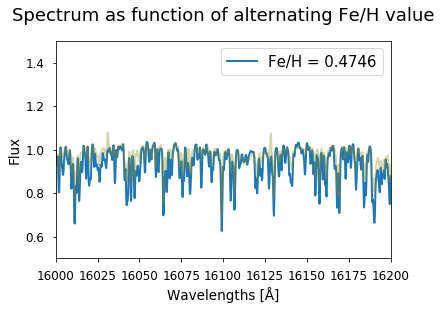

In [33]:
from matplotlib import animation

fig = plt.figure()
ax = plt.axes(xlim=(16000, 16200), ylim=(0.5, 1.5))
line, = ax.plot([], [], lw=2)

def init():
    plt.plot(wavelengths, mns, linewidth = 2, alpha = 0.2)
    line.set_data(wavelengths, model_metalicity[0])
    plt.title('Spectrum as function of alternating Fe/H value')
    plt.ylabel('Flux')
    plt.xlabel('Wavelengths [Å]')
    lb = 'Fe/H = %s' % round(Fe_H_alternating[0],4)
    plt.legend([lb])

    return line,

def animate(i):
    x = wavelengths
    y = model_metalicity[i]
    line.set_data(x, y)
    lb = 'Fe/H = %s' % round(Fe_H_alternating[i],4)
    plt.legend([lb])
    return line,

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=59, interval=20, blit=True)

anim.save('Altering_FE_H.mp4', fps=4, extra_args=['-vcodec', 'libx264'])


## 5.L Section L

A factor not accounted for in the spectral model is the fact that many stars are in binary systems. This can affect the spectra if the angular separation between the two components of a binary is small, as they will fall within the same spectroscopic fiber. Thus, the observed spectrum will really be the sum of the spectra of two different stars. This might affect the models result because the observable spectra becomes the superposition of two single star spectra. As stated by El-Badry et Al the 

    "combined spectrum of a binary system is in general different from that of either component,and fitting it with single-star models may yield inaccurate stellar parameters and abundances".
    
In their study they explored the effects of unresolved main-sequence binaries on spectral fitting. They found that fitting single-star models of unresolved binaries introduced systematic biases in the derived stellar parameters and abundances. They judged these effects as modest, but not at all negligible. The systematic errors were found to be of size 300K in the effective temperature, 0.1 dex in logg g and in Fe/H for APOGGE-like spectra of solar type stars. This might especially present a potential challenge when precise measurements of the labels of main-sequence stars are required. [El-Badry et Al, 2017](https://academic.oup.com/mnras/article/473/4/5043/4566523)

These findings are highly relevant for the challenge presented for the model above, as there is a risk for such spectra to be included in the imported data set. exactly how big this risk and challenge is are outside the scope of this study. However it should be remarked that the data this model is trained upon, and the data it is trying to fit very well might be such superposition of single-star spectra. This could possibly explain some of the offsets seen across all the approaches undertaken above to determine stellar labels from spectra. 

If such a systematic biases were to affect the results of the model, the bias is expected to go towards lower temperature and metallicity. El-Badry et al found that the strength of bias in best-fitting single-star labels would vary with temperature of the primary. The reason why systems with lower values of effective temperature on average have smaller systematic offsets is because the effective temperature is almost constant with mass along isochrones low on the main sequence. As suggested by El-Badry et Al, the biases may be corrected for by fitting spectra with a binary model. This would include adding two labels to the fit and include single star models as special cases. This seems like an approach that would be easy to implement in the above approach, as well as not very time consuming. El-Badry et Al found that by fitting such a binary model they could recover true parameters without systematic bias. Another feature of implementing such an approach was that the fitting of a binary model furthermore made it possible to spectroscopically identify main-sequence binary systems. 

# PART 6: Neural networks and stellar labels

## 6.M Section M

In this section a completely different way is used to measure labels from spectra. The following attempts to predict labels as a function of spectra directly through deep learning. A neural network is trained on the normalized spectra and predicts the same label vector that characterized the spectral model. To implement the machine learning technique the module kreas is imported from tensorflow. 

By experimenting on altering the modes, batch size and epochs of the neural network the network is tuned until the most reasonable result is found. Throughout the testing of different approaches to the network it was found that the result could be improved by cleansing the spectra a bit on beforehand. All gaps between the chips were removed before the data is processed. The neural network is then trained for so to be used to predict labels of stars in the cross validation set.  

The performance in terms of bias and median error for each label varies a lot from each time the network is trained, compared to the ASPCAP labels. The best values reach for the median error is for temperature in the range 50-40 K MSE, about 300-600 K RMS with a bias ranging from -20 to -18. For the log g and the abundances the sized tend to be of order 1.0-0.1 in RMS and 0.1-0.01 dex in both MSE and bias.

The networks performance actually compares quite poorly in relation to the model fitting done in part (h). This is although not surprising as there until the final results were quite big uncertainties regarding the effects of the networks different parameters. The results carries uncertainties in a range of about 10 to 40 times bigger than the first approach. This does not seem reasonable. The fact that the results varies so much as well from run to run is an indicator of something unstable in the implementation that is yet to be understood and controlled. 

One of the biggest disadvantages of using the ML neural network was the immediate loss of control over how the algorithm was handling the data and understanding the different components of the label determination. This approach was found a lot easier to implement, but a lot harder to figure out exactly how to maneuver. The first strategies of measuring labels was on the other hand harder to implement with the available resources, and demanded far more work to set up. Although, once the first spectral model was up running they were fairly easy to control and understand. In many ways it seemed as a safer platform to work from. On the other hand, even though the first implementation of this neural network did not turn out as great as the initial approach, it is believed that this method has a higher potential in the long run. By using larger sets of data and obtaining a deeper understanding of the components machine learning seems like a very efficient way of obtaining information about stellar labels quick. Although at a cost of high computational expenses while training the data. Once the data is trained, it appears to be quite efficient in applying the network onto new spectra and producing results. Maybe potentially way more efficient than the first approach in the long run after a training session is successfully completed. 

In [34]:
from sklearn import preprocessing
import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential
from keras.layers import Dense, Activation

print(tf.__version__)

1.13.1


Using TensorFlow backend.


In [35]:
y_train_chip = np.zeros((N_stars//2, 6300))
y_train_chip[:,0:2500] = y_train[:,500:3000]
y_train_chip[:,2500:4500] = y_train[:,3600:5600]
y_train_chip[:,4500:6900] = y_train[:,6400:8200]

y_test_chip = np.zeros((N_stars//2+1, 6300))
y_test_chip[:,0:2500] = y_test[:,500:3000]
y_test_chip[:,2500:4500] = y_test[:,3600:5600]
y_test_chip[:,4500:6900] = y_test[:,6400:8200]

X_train_scaled = y_train_chip
X_test_scaled = y_test_chip


y_train_labels = labels_train[:,1:6]
y_test_labels  = labels_test[:,1:6]


In [36]:
def nn_clf():
    model = Sequential()
    model.add(Dense(522, input_shape=(6300,), activation="linear", kernel_initializer='random_uniform'))
    model.add(Dense(210,  activation="linear", kernel_initializer='random_uniform'))
    model.add(Dense(419,  activation="linear", kernel_initializer='random_uniform'))
    model.add(Dense(5, activation="linear", kernel_initializer='random_uniform'))
    model.compile(optimizer='adam', loss='mean_squared_error',  metrics=['mae',"mse"])
    return model

In [37]:
nn_clf().summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 522)               3289122   
_________________________________________________________________
dense_2 (Dense)              (None, 210)               109830    
_________________________________________________________________
dense_3 (Dense)              (None, 419)               88409     
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 2100      
Total params: 3,489,461
Trainable params: 3,489,461
Non-trainable params: 0
_________________________________________________________________


In [44]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score, KFold

clf = KerasRegressor(build_fn=nn_clf, batch_size=50, epochs=100)
clf.fit(X_train_scaled, y_train_labels)

Epoch 1/100
824/824 [==============================] - 1s 1ms/step - loss: 6.7633 - mean_absolute_error: 1.7756 - mean_squared_error: 6.7633
Epoch 2/100
824/824 [==============================] - 1s 841us/step - loss: 1.6811 - mean_absolute_error: 1.0270 - mean_squared_error: 1.6811
Epoch 3/100
824/824 [==============================] - 1s 849us/step - loss: 1.1169 - mean_absolute_error: 0.8188 - mean_squared_error: 1.1169
Epoch 4/100
824/824 [==============================] - 1s 856us/step - loss: 1.0861 - mean_absolute_error: 0.8147 - mean_squared_error: 1.0861
Epoch 5/100
824/824 [==============================] - 1s 829us/step - loss: 0.9896 - mean_absolute_error: 0.7721 - mean_squared_error: 0.9896
Epoch 6/100
824/824 [==============================] - 1s 843us/step - loss: 0.8876 - mean_absolute_error: 0.7348 - mean_squared_error: 0.8876
Epoch 7/100
824/824 [==============================] - 1s 856us/step - loss: 0.7974 - mean_absolute_error: 0.6833 - mean_squared_error: 0.7974
E

Epoch 58/100
824/824 [==============================] - 1s 780us/step - loss: 0.4145 - mean_absolute_error: 0.4710 - mean_squared_error: 0.4145
Epoch 59/100
824/824 [==============================] - 1s 797us/step - loss: 0.3589 - mean_absolute_error: 0.4234 - mean_squared_error: 0.3589
Epoch 60/100
824/824 [==============================] - 1s 775us/step - loss: 0.4475 - mean_absolute_error: 0.5008 - mean_squared_error: 0.4475
Epoch 61/100
824/824 [==============================] - 1s 777us/step - loss: 0.4035 - mean_absolute_error: 0.4569 - mean_squared_error: 0.4035
Epoch 62/100
824/824 [==============================] - 1s 771us/step - loss: 0.3966 - mean_absolute_error: 0.4687 - mean_squared_error: 0.3966
Epoch 63/100
824/824 [==============================] - 1s 779us/step - loss: 0.4031 - mean_absolute_error: 0.4642 - mean_squared_error: 0.4031
Epoch 64/100
824/824 [==============================] - 1s 805us/step - loss: 0.4160 - mean_absolute_error: 0.4717 - mean_squared_error:

MSE in  T_eff  : 116.25646711139767
RMS in  T_eff  : 533.207556021497
BIAS in  T_eff  : 18.552650035511363
-------------------------------------------
MSE in  Log g  : 0.281953236520208
RMS in  Log g  : 1.3918306197420018
BIAS in  Log g  : 0.048427945375442503
-------------------------------------------
MSE in  Mg/Fe  : 0.0810837553591384
RMS in  Mg/Fe  : 0.4416817345178626
BIAS in  Mg/Fe  : -0.015368061752030343
-------------------------------------------
MSE in  Si/Fe  : 0.07052093169811045
RMS in  Si/Fe  : 0.6367600443601814
BIAS in  Si/Fe  : -0.02215569926982591
-------------------------------------------
MSE in  Fe/H  : 0.1380856199735946
RMS in  Fe/H  : 2.892178778531204
BIAS in  Fe/H  : 0.10063169606707313
-------------------------------------------


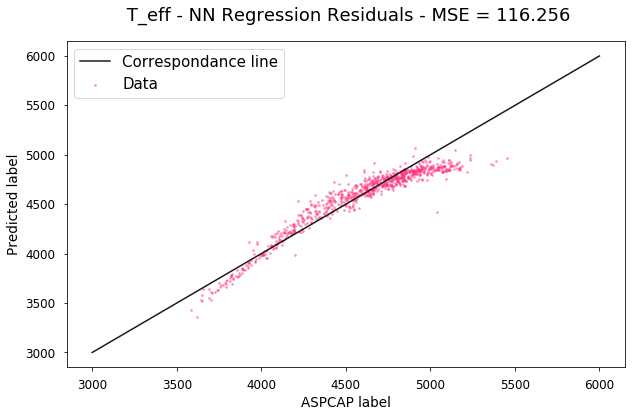

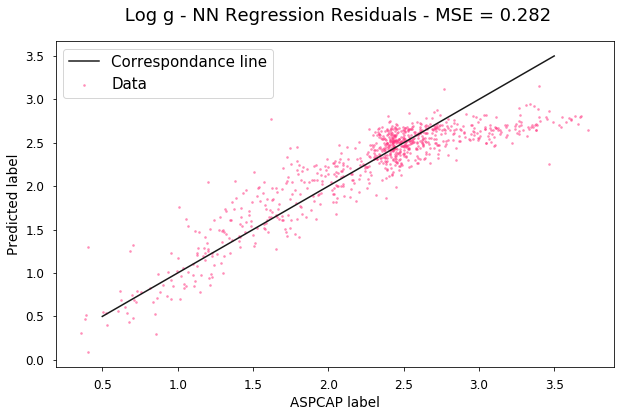

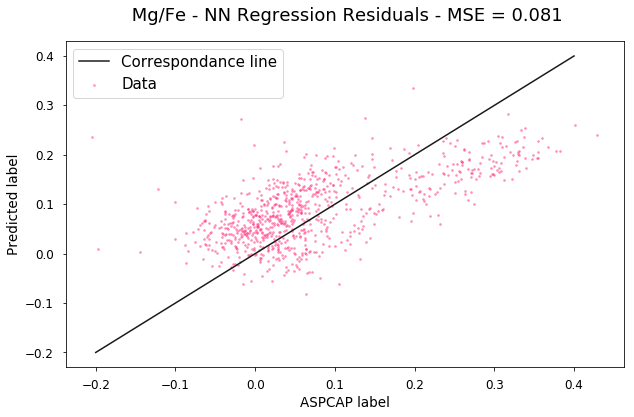

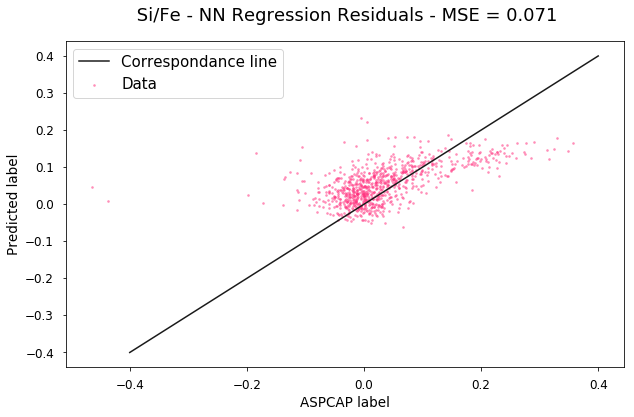

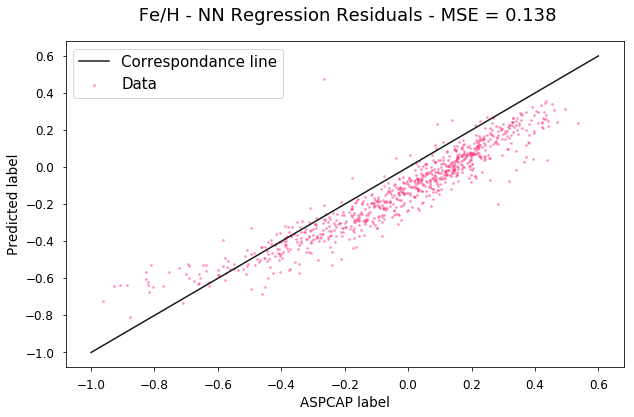

In [45]:
# how well did we do?
import numpy as np
from sklearn.metrics import mean_squared_error

def predictions(index, label):
    y    = scaler.inverse_transform(y_test_labels)[:,index]
    pred = scaler.inverse_transform(clf.predict(X_test_scaled))[:,index]


    mse = np.sqrt(mean_squared_error(y, pred)) ; print("MSE in ",label, " :",mse)
    rms = np.sqrt(np.sum(y-pred)**2/(len(y)-1)); print("RMS in ",label, " :",rms)
    bias    = 1/len(y)*np.sum(y-pred); print('BIAS in ',label, " :", bias)
    
    plt.figure(figsize=(10,6))
    plt.title(" %s - NN Regression Residuals - MSE = %.3f" % (label, mse))
    plt.scatter(y,pred,alpha=0.4,s=3, c = (1,0.2,0.5))
    plt.xlabel("ASPCAP label")
    plt.ylabel("Predicted label")
    print('-------------------------------------------')
    #plt.ylim((-3,3))    
    
predictions(0, 'T_eff')
plt.plot([3000,6000],[3000,6000],c=(0.1,0.1,0.1))
plt.legend(['Correspondance line', 'Data'])
predictions(1, 'Log g')
plt.plot([0.5,3.5],[0.5,3.5],c=(0.1,0.1,0.1))
plt.legend(['Correspondance line', 'Data'])
predictions(2, 'Mg/Fe')
plt.plot([-0.2,0.4],[-0.2,0.4],c=(0.1,0.1,0.1))
plt.legend(['Correspondance line', 'Data'])
predictions(3, 'Si/Fe')
plt.plot([-0.4,0.4],[-0.4,0.4],c=(0.1,0.1,0.1))
plt.legend(['Correspondance line', 'Data'])
predictions(4, 'Fe/H')
plt.plot([-1,0.6],[-1,0.6],c=(0.1,0.1,0.1))
plt.legend(['Correspondance line', 'Data'])

# Conclusion

In this study a generative model for predicting stellar labels from spectra was constructed and applied to observations done by the APOGEE survey. The results were compared to the label associated with the spectra derived by the ASPCAP pipeline. In total 2723 spectra is initially retrieved from the SDSS database using wget. Two illustrative plots of two random spectra is presented, as well as a corner plot illustrating the covariance amongst labels derived by the ASPCAP pipeline. Following in the example of Ness et all, the data is cleansed and continuum normalized to yield a comparative basis for all spectra. The data is cleansed using the APOGEE bit masks, as well as requirements on the SNR and metallicity abundance. The cleansing and retrieving of data appeared to have been done sufficiently efficient.

To build a spectral model the exhaustive set of labels underlying the spectra was approximated by choosing the effective temperature, surface gravitation and metallicity abundances of Fe/H, Mg/Fe and Si/Fe. As well, a linear offset parameter was implemented in spectral model. The label vector was expanded up to second order, and then the spectral model was trained on 824 spectra to create a set of label coefficients. These coefficients were used alongside a minimization of the log likelihood function to find the labels closest in label space with the spectra. The model was then applied to a cross-validation set of 825 stars, and turned out to work quite well as a predicative model in regards to the ASPCAP derived values. Yielding results like an RMS of 46 K in the effective temperature and a RMS of 0.268  Dex in the Fe/H ratio. When inspecting the Kiel diagram of the estimated temperature, gravitation and Fe/H ratio the results were found to be consistent with theoretical expectations and Holtzman et al. 

After testing the initial stellar label model, another approach using McMc was used to fit a mystery stellar spectrum. This seems to work out well, using the same log likelihood as the stellar label model and uniformed priors. The errors found was on the same scale as the once of the first model, and even a bit smaller. Still, this way of estimating labels were found computationally expensive. It does not appear as a good approach when handling a larger set of spectra. Then the study returned back to look at the metallicity abundances affect on the stellar spectra. An animation was made where all 4 labels except Fe/H were held constant, and Fe/H were varying from -1 to 0.5. The effect on the spectra were evident, deepening and producing more absorption lines in the spectra when the metallicity ratio increased. In the very end of this study a completely different approach was made to determine stellar labels. A Keeras neural network were applied to the training set of spectra and used to infer labels of the test spectra. This were found to be easy to implement, but had a more demanding trial and error phase to approach an answer whose errors was considerably larger than the ones of the other approaches. This method is considered to have potential, but further analysis is necessary in order to improve this method sufficiently.

The study was overall very successful in illustrating how larger sets of spectra can be processed simultaneously, as was the initial goal. It was interesting to see consistency across the different methods, and to evaluate how they might be good approaches in different contexts. Like how the mcmc yielded smaller errors, but probably is not suited for larger analysis at its' current stage. We hope that this study has been illustrative of showing the power of the approaches undertaken, as well as the challenges they all propose. In further studies the methods could be more refined by obtaining a better understanding of critical concepts like the continuum normalization, the priors stated in the mcmc and the workings of the neural net. 

# References 

[1] Majewski, S. R., Schiavon, R. P., Allende Prieto, C., et al. 2015, arXiv:1509.05420v1 [astro-ph.IM]
[2] Holtzman, J. .A., Shetrone, M., Allende Prieto, C., Y., et al.2015, arXiv:1501.04110 [astro-ph.GA]
[3] Ness, M., Hogg, D. W. , Rix, H., Ho,  A. Y. Q., Zasowski, G, 2015, arXiv:1501.07604 [astro-ph.SR]
[4] Majewski Et al., 2015,  	arXiv:1509.05420 [astro-ph.IM]
[5] El-Badry Et. Al, 2018

# Appendix 

## 1.A About Wget

Wget stands for “web get” and is a non-interactive command line tool which downloads files over a network. It can create local versions of the remote website, by fully recreating the directory structure of the original site, often referred to as “recursive downloading”. This command is here applied to the directory urls of the 4 desired locations IDs. To efficiently retrieve all data directly to the hub three command-line options are included. 

1. -r : recursive → Turns on recursive retrieving. I.e. traverses the http presented by following links and directory structure. This allows us to download all the .fits files associated witch the current location ID. 

2. -q : Turn off wget's output

3. [--np: no parents](https://www.gnu.org/software/wget/manual/html_node/Directory_002dBased-Limits.html). Limits the directories by disallowing retrieval of links that refer to the hierarchy above the beginning directory. I. E. disallowing ascent to the parent directories, and basically makes sure we do not download the entire network by not following the parent directory links 

4. -nd : All files saved to current directory

5. -e : Execute command as if it were part of a file, a command thus invoked will be executed after the commands in .wgetrc.

6. [-- robots = off](https://www.gnu.org/software/wget/manual/html_node/Robot-Exclusion.html) : The robot exclusion exist to prevent Wget from wandering aimlessly around a website. By this command Wget is forced to ignore the robot exclusion standard (robots.txt), and are able to complete the download of the links.

7. -P : Set directory prefix to prefix

8. -A, -R : Specify comma-separated lists of file name suffixes or patterns to accept or reject.

More information about Wget can be obtained [here](https://www.computerhope.com/unix/wget.htm).


## Data-Based Estimates of Descriptive Statistics

Ivezic et al. defines bias as "the expectation value of the
difference between the estimator and its true (population) value. Estimators whose
variance and bias vanish as the sample size goes to infinity are called consistent
estimators". It is measured as

<center> $$bias =\dfrac{1}{N_{Stars}}\sum_{n=0}{N}(y-\bar{y})$$ <center>